# Plotting Notebook
This notebook displays and manipulates the histograms produced by `make_plots.py`. <br>
Please use this is a guide to the type plots that you can create, as examples of the `hist`, `mplhep`, and other packages, as well as the use of the various functions that we have written in `plot_utils.py`. <br>
Use the the Table of Contents in Jupyter to view the different sections of the notebook to help navigating it.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
import os, sys, glob
import pickle
import math
import itertools
import warnings
import json
import numpy as np
from typing import Dict, List
from rich.pretty import pprint
from rich.console import Console
from rich.table import Table
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import hist
from hist import Hist
import mplhep as hep
from tabulate import tabulate
import scipy
%aimport plot_utils
%aimport fill_utils

warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'figure.max_open_warning': 0})
matplotlib.rcParams['figure.facecolor'] = 'white'
plt.style.use(hep.style.CMS)

In [4]:
print("The following output directories are available:")
!ls | grep output_histograms

The following output directories are available:
CR_cb_34mu_output_histograms
CR_cb_output_histograms
CR_prompt_34mu_leading_output_histograms
CR_prompt_34mu_output_histograms
CR_prompt_dimuon_output_histograms
CR_prompt_dystudy_output_histograms
CR_prompt_leading_output_histograms
CR_prompt_output_histograms
DYstudy_2_output_histograms
DYstudy_3_output_histograms
DYstudy_4_output_histograms
DYstudy_5_output_histograms
DYstudy_output_histograms
DYstudy_trigger_match_double_output_histograms
DYstudy_trigger_match_triple_output_histograms
nbjet_comparison_output_histograms
temp_output_histograms


## Notebook Parameters
The following couple cells define the input and output directories, and load in the desired .pkl files into the `plots` nested dictionary.<br>
`output_label`: _str_, saves plots as `<output_label>+<plot_name>.<file_ext>`.<br>
`file_ext`: _str_, see above.<br>

In [5]:
# parameters
output_label = './output_plots/'
file_ext = '.png'

The `plots` dictionary is used to store all the plots imported from the pickle files. Dimensions: (sample) x (plot label) <br>
The `loader` function in `plot_utils.py` automatically merges all the QCD HT and QCD pT bins into one sample ('QCD_HT' and 'QCD_Pt'), applies the lumis, and excludes some of the low QCD bins.<br>

In [9]:
# create output dir
if not os.path.isdir(output_label): 
    print("Creating", output_label)
    os.mkdir(output_label)

# This part is meant to be flxeible, depending on what you want to import
# dimensions of plots: (sample) x (plot label)
# N.B.: lumis are applied through loader()

# input .pkl files
plotDir = './DYstudy_trigger_match_double_output_histograms/'
infile_names = glob.glob(plotDir+'*.pkl')

# generate list of files that you want to merge histograms for
offline_files_SUEP = [
    f for f in infile_names if ("SUEP" in f) and ("histograms.pkl" in f)
]
offline_files_normalized = [
    f for f in infile_names if ("normalized.pkl" in f)
]
offline_files_other = [
    f for f in infile_names if ("pythia8" in f) and ("histograms.pkl" in f)
]
offline_files = offline_files_normalized + offline_files_other
pprint(offline_files)

data_files = [
    f for f in infile_names if ("DoubleMuon" in f) and ("histograms.pkl" in f)
]
pprint(data_files)

other_bkg_names = {
    "DY0JetsToLL": "DY0JetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8",
    "DYJetsToLL_NLO": "DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8",
    "DYLowMass_NLO": "DYJetsToLL_M-10to50_TuneCP5_13TeV-amcatnloFXFX-pythia8+"
                     "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM",
    "DYLowMass_LO": "DYJetsToLL_M-10to50_TuneCP5_13TeV-madgraphMLM-pythia8+"
                    "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM",
    "TTJets": "TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8+"
              "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM",
    "ttZJets": "ttZJets_TuneCP5_13TeV_madgraphMLM_pythia8+"
               "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM",
    "WWZ_4F": "WWZ_4F_TuneCP5_13TeV-amcatnlo-pythia8+"
              "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1_ext1-v2+MINIAODSIM",
    "ZZTo4L": "ZZTo4L_TuneCP5_13TeV_powheg_pythia8+"
              "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM",
    "ZZZ": "ZZZ_TuneCP5_13TeV-amcatnlo-pythia8+"
           "RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1_ext1-v2+MINIAODSIM",
    "WJets_inclusive": "WJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-pythia8+"
                 "RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM",
    "ST_tW": "ST_tW_Dilept_5f_DR_TuneCP5_13TeV-amcatnlo-pythia8+"
             "RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM"
}

# merge the histograms, apply lumis, exclude low HT bins
plots_SUEP_2018 = plot_utils.loader(offline_files_SUEP, year=2018, custom_lumi=1005.939459)
plots_2018 = plot_utils.loader(offline_files, year=2018, custom_lumi=1005.939459)
plots_data = plot_utils.loader(data_files, year=2018, is_data=True)

# put everything in one dictionary, apply lumi for SUEPs
plots = {}
for key in plots_SUEP_2018.keys(): 
    plots[key+"_2018"] = fill_utils.apply_normalization(
        plots_SUEP_2018[key], 
        fill_utils.getXSection(key+'+RunIIAutumn18-private+MINIAODSIM', '2018', SUEP=True)
    )
for key in plots_2018.keys():
    is_binned = False
    binned_samples = [
        "QCD_Pt",
        "WJetsToLNu_HT",
        "WZTo",
        "WZ_all",
        "WWTo",
        "WW_all",
        "ST_t-channel",
        "JetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8",
        "DYNJetsToLL",
    ]
    for binned_sample in binned_samples:
        if binned_sample in key:
            is_binned = True
    if is_binned and ('normalized' not in key) and ('cutflow' in key):
        continue
    if is_binned or ('bkg' in key):
        plots[key+"_2018"] = plots_2018[key]
    else:
        plots[key+"_2018"] = fill_utils.apply_normalization(
            plots_2018[key], 
            fill_utils.getXSection(other_bkg_names[key], '2018', SUEP=False)
        )

for key in plots_data.keys(): 
    plots[key+"_2018"] = plots_data[key]

# Apply global scaling factor
#global_scaling_factor = 0.6
global_scaling_factor = 1.0
for key1 in plots.keys():
    if "DoubleMuon" in key1:
        continue
    for key2 in plots[key1].keys():
        plots[key1][key2] = plots[key1][key2] * global_scaling_factor

# Apply NNLO xs to DYJet_NLO
# if "DYJetsToLL_NLO_2018" in plots.keys():
#    for plot in plots["DYJetsToLL_NLO_2018"].keys():
#        plots["DYJetsToLL_NLO_2018"][plot] = plots["DYJetsToLL_NLO_2018"][plot] * 1.0 #6000 / 6424

# Normalize QCD MuEnriched if it exists
# factor_1 = 0.65
factor_1 = 1.0
if "QCD_Pt_MuEnriched_2018" in plots.keys():
    for plot in plots["QCD_Pt_MuEnriched_2018"].keys():
        plots["QCD_Pt_MuEnriched_2018"][plot] = plots["QCD_Pt_MuEnriched_2018"][plot] * factor_1

[
│   './DYstudy_trigger_match_double_output_histograms/QCD_Pt-1000_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './DYstudy_trigger_match_double_output_histograms/QCD_Pt-120To170_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './DYstudy_trigger_match_double_output_histograms/QCD_Pt-15To20_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './DYstudy_trigger_match_double_output_histograms/QCD_Pt-170To300_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './DYstudy_trigger_match_double_output_histograms/QCD_Pt-20To30_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './DYstudy_trigger_match_double_output_histograms/QCD_Pt-300To470_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './DYstudy_trigger_match_double_output_histograms/QCD_Pt-30To50_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './DYstudy_trigger_match_double_output_histograms/QCD_Pt-470To600_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './DYstudy_trigger_match_double_output_histograms/QCD_Pt-50To80_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './DYstudy_trigger_match_double_output_histograms/QCD_Pt-600To800_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './DYstudy_trigger_match_double_output_histograms/QCD_Pt-800To1000_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './DYstudy_trigger_match_double_output_histograms/QCD_Pt-80To120_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized.pkl',
│   './DYstudy_trigger_match_double_output_histograms/WZTo3LNu_5f_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms_normalized.pkl',
│   './DYstudy_trigger_match_double_output_histograms/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM_histograms.pkl',
│   './DYstudy_trigger_match_double_output_histograms/ZZTo4L_TuneCP5_13TeV_powheg_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM_histograms.pkl',
│   './DYstudy_trigger_match_double_output_histograms/DYJetsToLL_M-10to50_TuneCP5_13TeV-amcatnloFXFX-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms.pkl',
│   './DYstudy_trigger_match_double_output_histograms/WZTo3LNu_5f_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1+NANOAODSIM_histograms.pkl',
│   './DYstudy_trigger_match_double_output_histograms/DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms.pkl',
│   './DYstudy_trigger_match_double_output_histograms/QCD_Pt-1000_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms.pkl',
│   './DYstudy_trigger_match_double_output_histograms/QCD_Pt-120To170_MuEnrichedPt5_TuneCP5_13TeV-pythia8+R

[
│   './DYstudy_trigger_match_double_output_histograms/DoubleMuon+Run2018A-UL2018_MiniAODv2-v1+MINIAOD_histograms.pkl'
]

These are all the samples loaded.

In [7]:
bkgs = [
    'VVV_2018',
    'ttZJets_2018',
    'WZ_all_2018',
    'ZZTo4L_2018',
    'TTJets_2018',
    'DYCombined_2018',
    'QCD_Pt_2018',
]
plots_sources = plot_utils.split_bkgs(plots=plots, bkg_list=bkgs)
plots.update(plots_sources)
plots_sources_per_process = plot_utils.split_bkgs_per_process(plots=plots, bkg_list=bkgs)

KeyError: 'VVV_2018'

In [ ]:
processes = [
    'VVV_2018',
    'ttZJets_2018',
    'WZ_all_2018',
    'ZZTo4L_2018',
    'TTJets_2018',
    'DYCombined_2018',
    'QCD_Pt_2018',
]
sources = [
    "c/b",
    "light/other",
    "prompt",
]
plots_processes_per_source = plot_utils.invert_dict(plots_sources_per_process, processes, sources)

In [11]:
keys = list(plots.keys())
pprint(keys)

[
│   'SUEP-m125-darkPho_2018',
│   'SUEP-m125-darkPhoHad_2018',
│   'SUEP-m400-darkPho_2018',
│   'SUEP-m400-darkPhoHad_2018',
│   'SUEP-m750-darkPho_2018',
│   'SUEP-m750-darkPhoHad_2018',
│   'SUEP-m1000-darkPho_2018',
│   'SUEP-m1000-darkPhoHad_2018',
│   'DY1JetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer19UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'bkg_2018',
│   'DYNJetsToLL_2018',
│   'DY2JetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer19UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'DY3JetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer19UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'DY4JetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer19UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_Pt-1000_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt_MuEnriched_2018',
│   'QCD_Pt-120To170_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt-15To20_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt-170To300_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt-20To30_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt-300To470_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt-30To50_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt-470To600_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt-50To80_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt-600To800_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt-800To1000_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt-80To120_MuEnrichedPt5_TuneCP5_13TeV-pythia8+RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2+NANOAODSIM_histograms_normalized_2018',
│   'QCD_Pt_1000to1400_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_Pt_2018',
│   'QCD_Pt_120to170_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM_histograms_normalized_2018',
│   'QCD_Pt_1400to1800_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_Pt_15to30_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_Pt_170to300_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_Pt_1800to2400_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_Pt_2400to3200_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_histograms_normalized_2018',
│   'QCD_Pt_30

In [19]:
for key in plots['QCD_Pt_MuEnriched_2018'].keys():
    pprint(f"{key = }")

"key = 'ht'"

"key = 'nJet_vs_nGenJet_vs_nMuon'"

"key = 'LHE_Njets_vs_Nglu_vs_Nuds_vs_Nc_vs_Nb_vs_nMuon'"

"key = 'LHE_Njets_vs_nMuon_vs_nMuon_nonprompt_vs_nMuon_nonprompt_reco'"

"key = 'nMuon_unmatched_vs_nMuon_prompt_vs_nMuon_light_vs_nMuon_c_vs_nMuon_b_vs_nMuon_tau'"

"key = 'muon_pt_linear_vs_genPartFlav_vs_nMuon'"

"key = 'muon_pt_vs_genPartFlav_vs_nMuon'"

"key = 'muon_eta_vs_genPartFlav_vs_nMuon'"

"key = 'muon_phi_vs_genPartFlav_vs_nMuon'"

"key = 'muon_dxy_vs_genPartFlav_vs_nMuon'"

"key = 'muon_dz_vs_genPartFlav_vs_nMuon'"

"key = 'muon_miniPFRelIso_vs_genPartFlav_vs_nMuon'"

"key = 'muon_btagDeepFlavB_vs_genPartFlav_vs_nMuon'"

"key = 'muon_matched_jetPtRelv2_vs_genPartFlav_vs_nMuon'"

"key = 'muon_matched_jetRelIso_vs_genPartFlav_vs_nMuon'"

"key = 'all_pairs_deltaangle_vs_nMuon'"

"key = 'all_pairs_dR'"

"key = 'leading_dimuon_pair_deltaR'"

"key = 'leading_muon_iso_vs_subleading_muon_iso'"

"key = 'leading_os_dimuon_pair_pt_vs_mass'"

"key = 'leading_os_dimuon_pair_log_pt_vs_mass'"

## Section with histograms for fitting

Will plot:
  - dxy
  - pt
  - PFIso
  - nTrack
  - nMuon
  
both as stacked & non-stacked plots.

In [10]:
for key in plots['DoubleMuon+Run2018A-UL2018_MiniAODv2-v1+MINIAOD_histograms_2018'].keys():
    pprint(f"{key = }")

"key = 'ht'"

"key = 'nJet_vs_nGenJet_vs_nMuon'"

"key = 'LHE_Njets_vs_Nglu_vs_Nuds_vs_Nc_vs_Nb_vs_nMuon'"

"key = 'LHE_Njets_vs_nMuon_vs_nMuon_nonprompt'"

"key = 'nMuon_unmatched_vs_nMuon_prompt_vs_nMuon_light_vs_nMuon_c_vs_nMuon_b_vs_nMuon_tau'"

"key = 'muon_pt_linear_vs_genPartFlav_vs_nMuon'"

"key = 'muon_pt_vs_genPartFlav_vs_nMuon'"

"key = 'muon_eta_vs_genPartFlav_vs_nMuon'"

"key = 'muon_phi_vs_genPartFlav_vs_nMuon'"

"key = 'muon_dxy_vs_genPartFlav_vs_nMuon'"

"key = 'muon_dz_vs_genPartFlav_vs_nMuon'"

"key = 'muon_miniPFRelIso_vs_genPartFlav_vs_nMuon'"

"key = 'muon_btagDeepFlavB_vs_genPartFlav_vs_nMuon'"

"key = 'muon_matched_jetPtRelv2_vs_genPartFlav_vs_nMuon'"

"key = 'muon_matched_jetRelIso_vs_genPartFlav_vs_nMuon'"

"key = 'all_pairs_deltaangle_vs_nMuon'"

"key = 'all_pairs_dR'"

"key = 'leading_dimuon_pair_deltaR'"

"key = 'leading_muon_iso_vs_subleading_muon_iso'"

"key = 'leading_os_dimuon_pair_pt_vs_mass'"

"key = 'leading_os_dimuon_pair_log_pt_vs_mass'"

In [11]:
for key in plots['c/b'].keys():
    pprint(key)

KeyError: 'c/b'

In [ ]:
plots['DYJetsToLL_NLO_2018']['muon_pt_vs_genPartFlav_vs_nMuon'][:, ::sum, 0:4:sum]

## Show post-cut plots

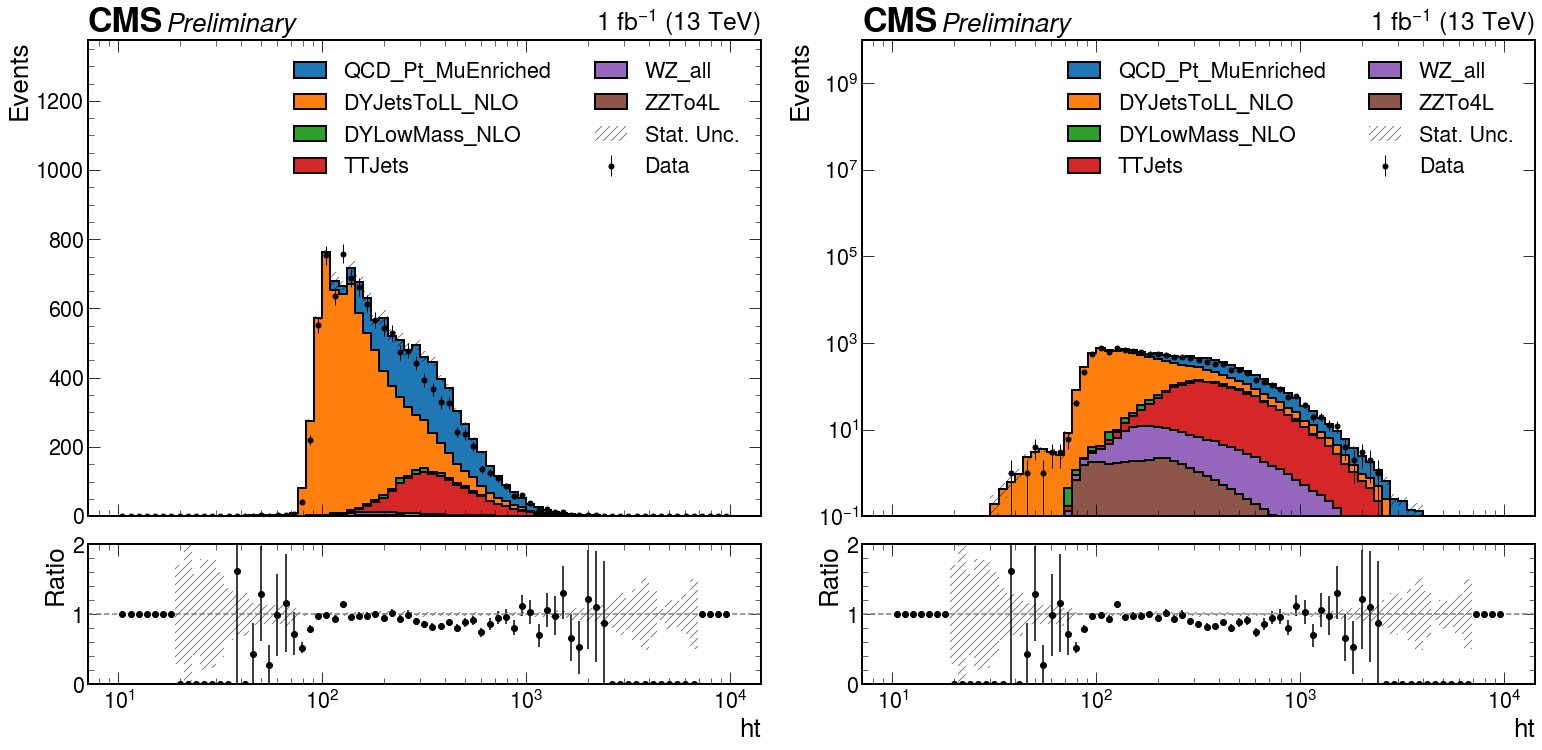

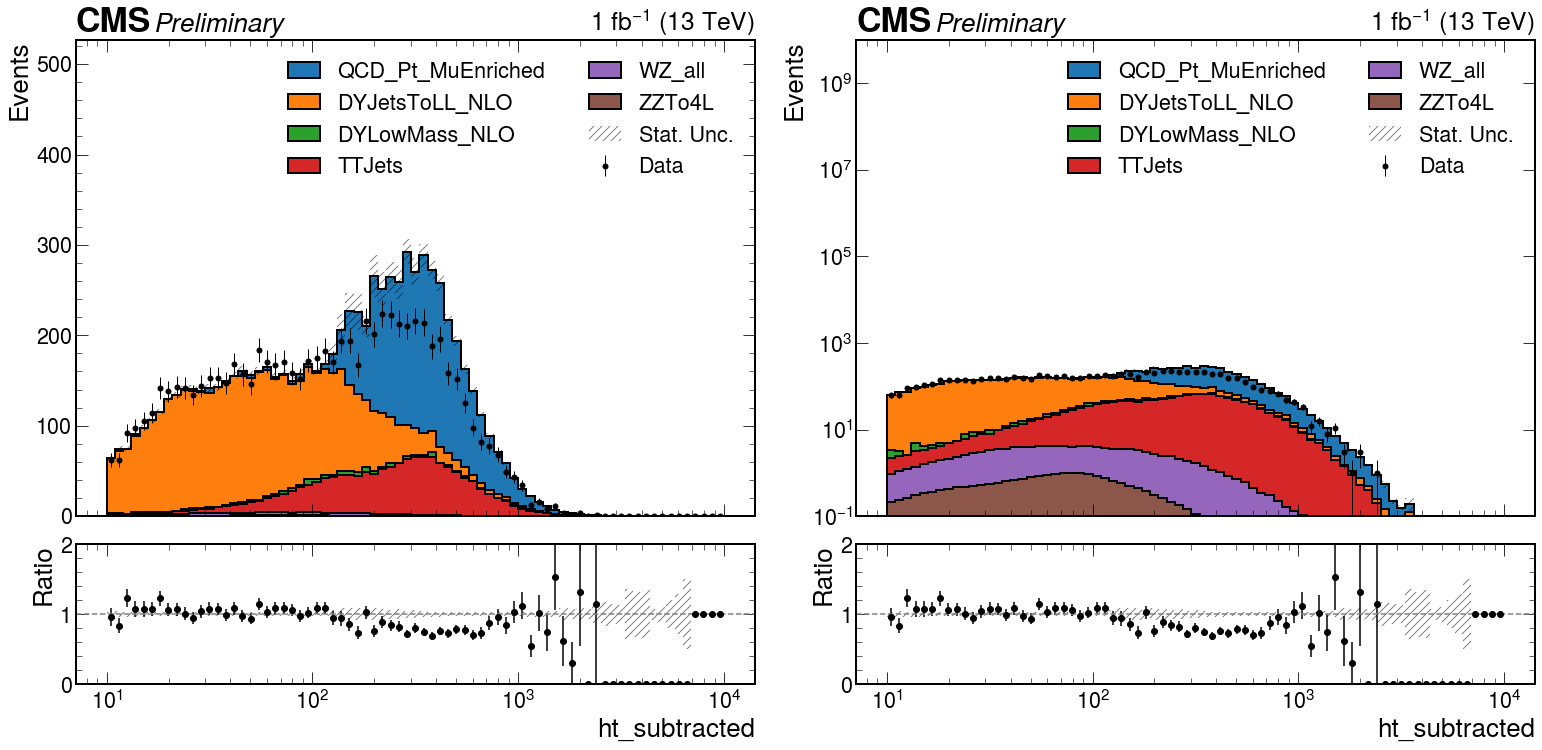

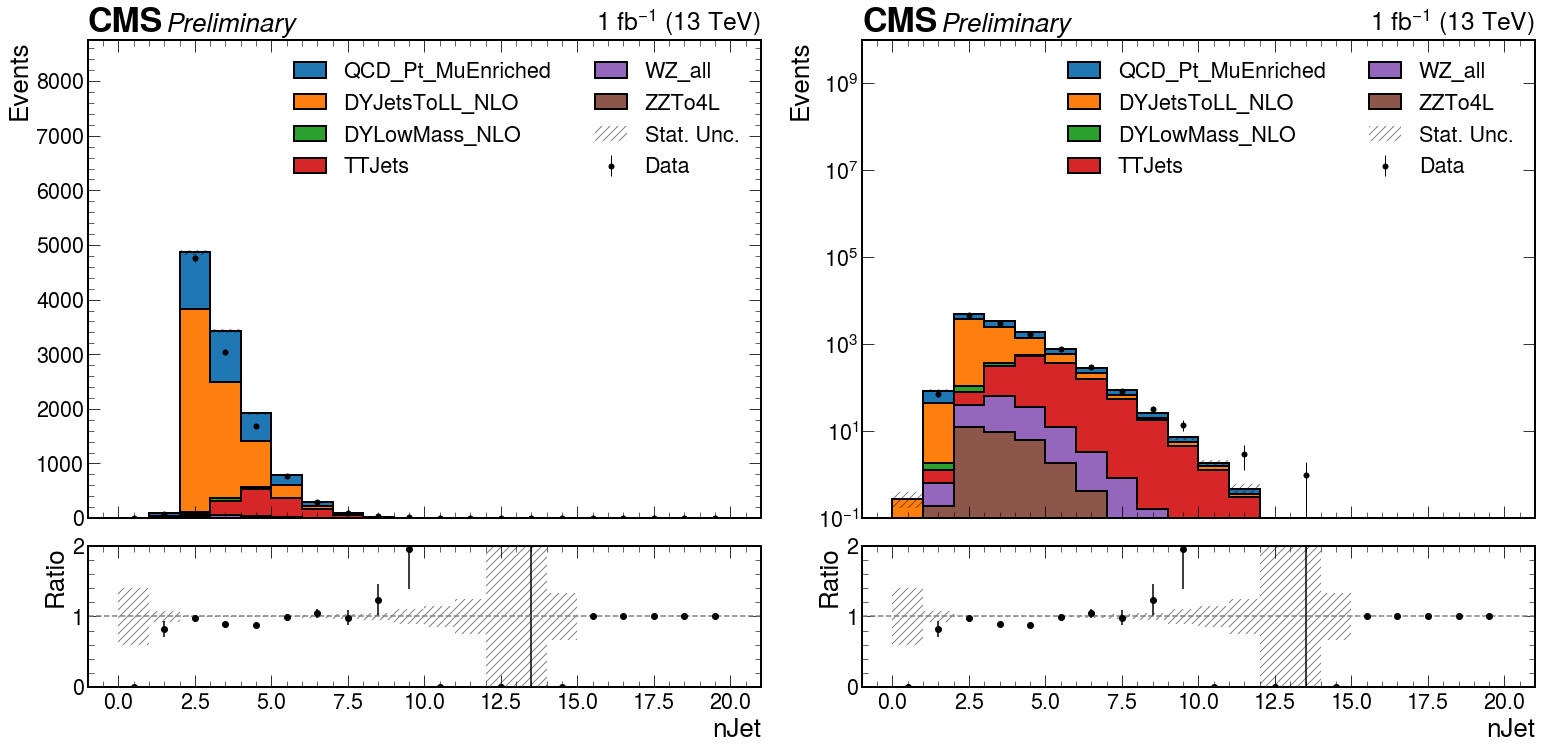

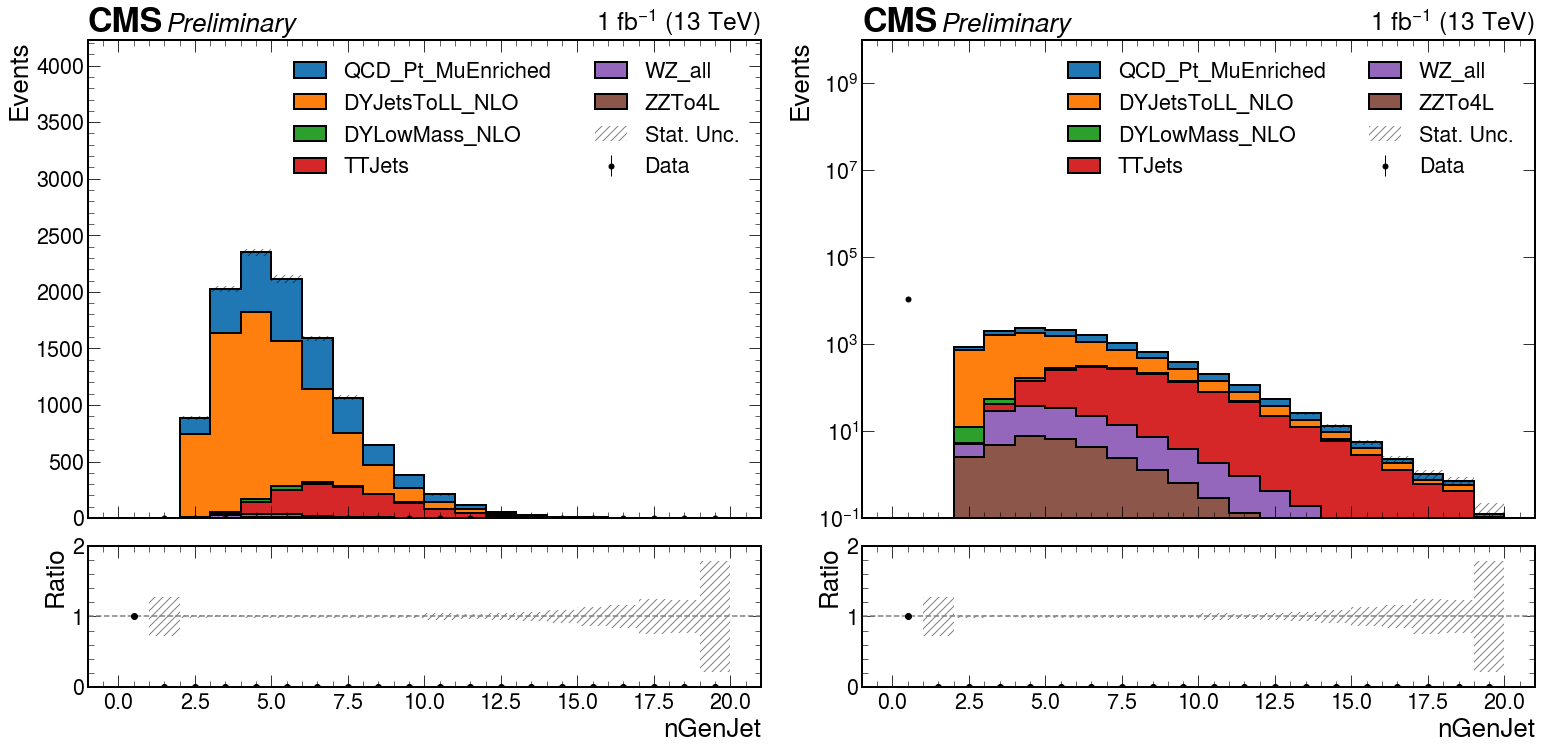

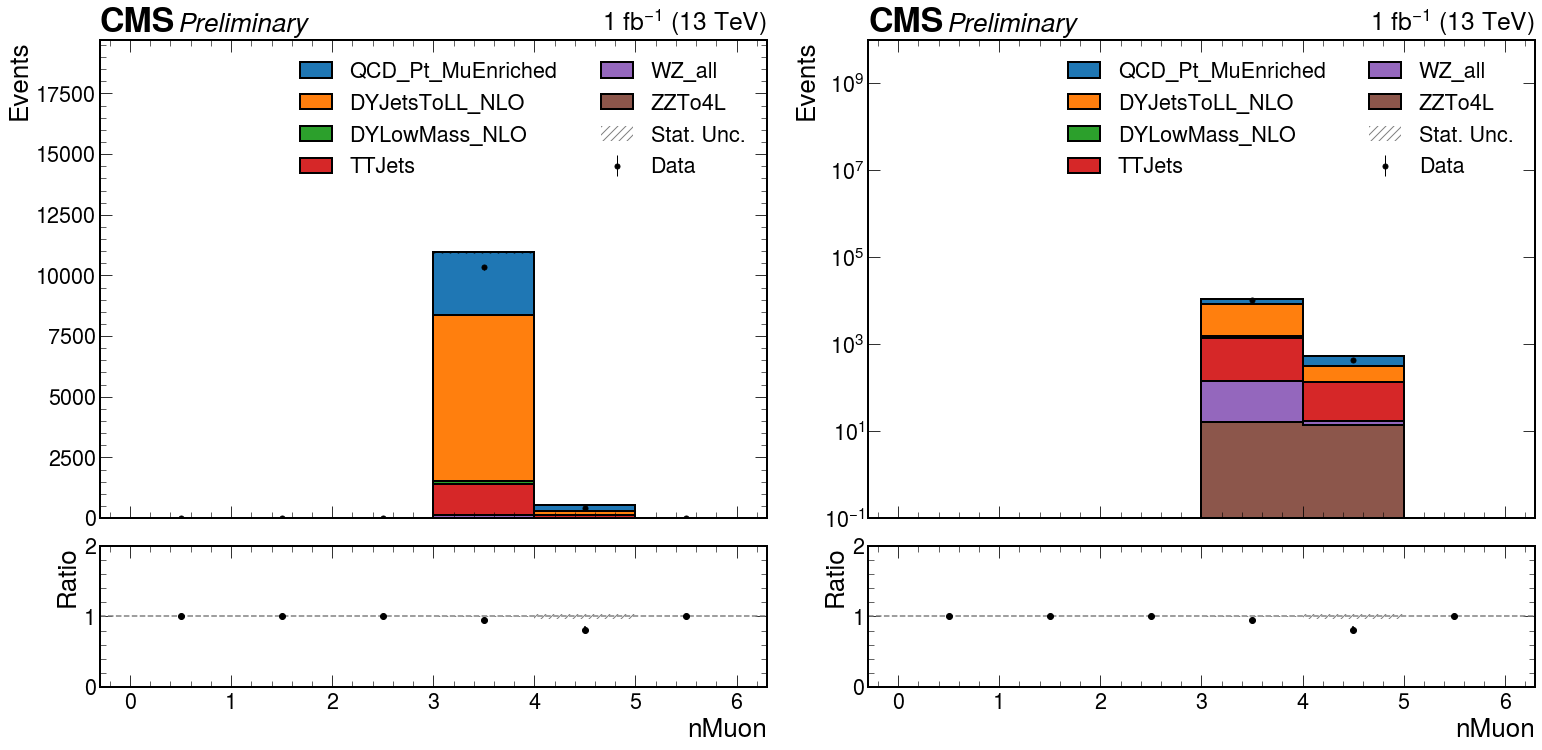

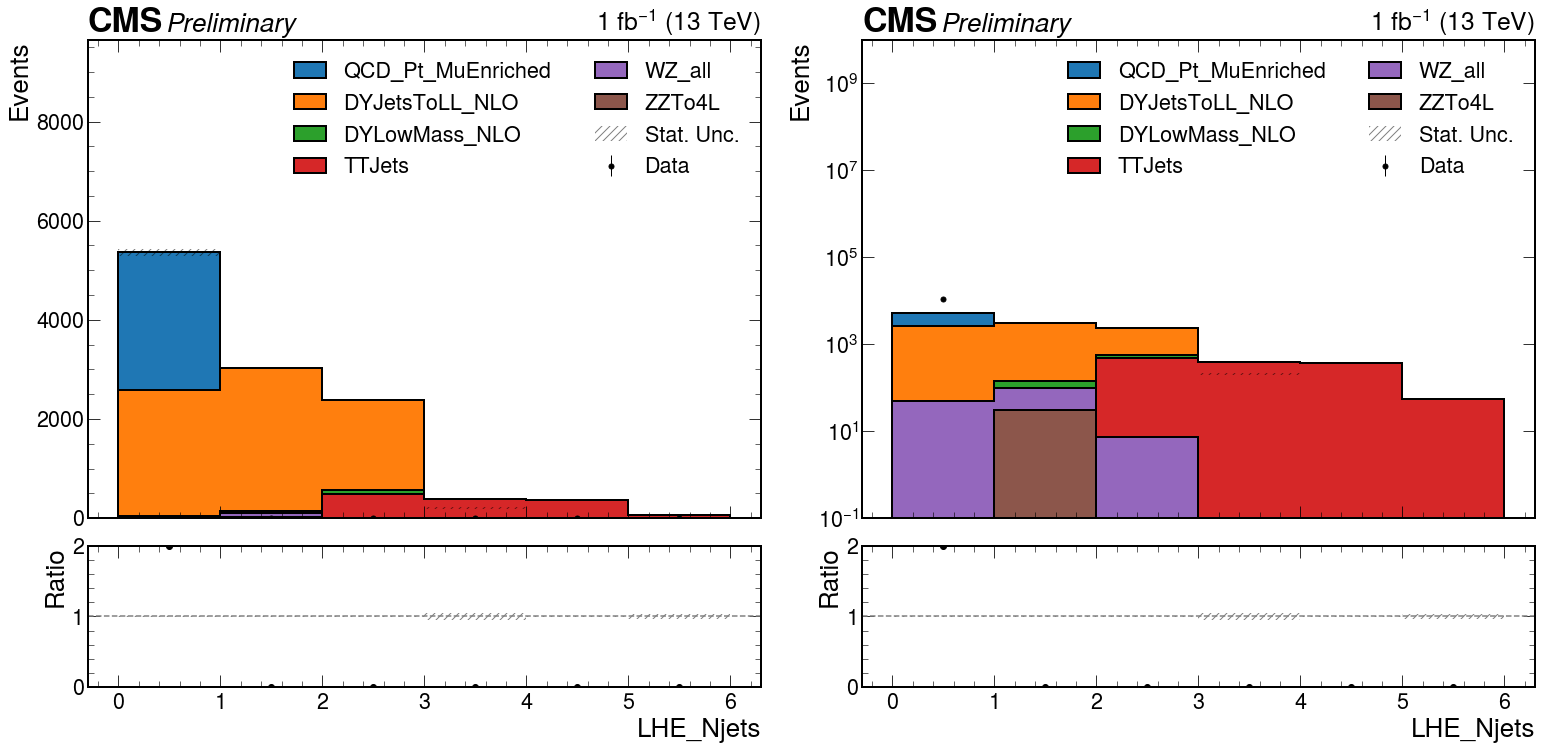

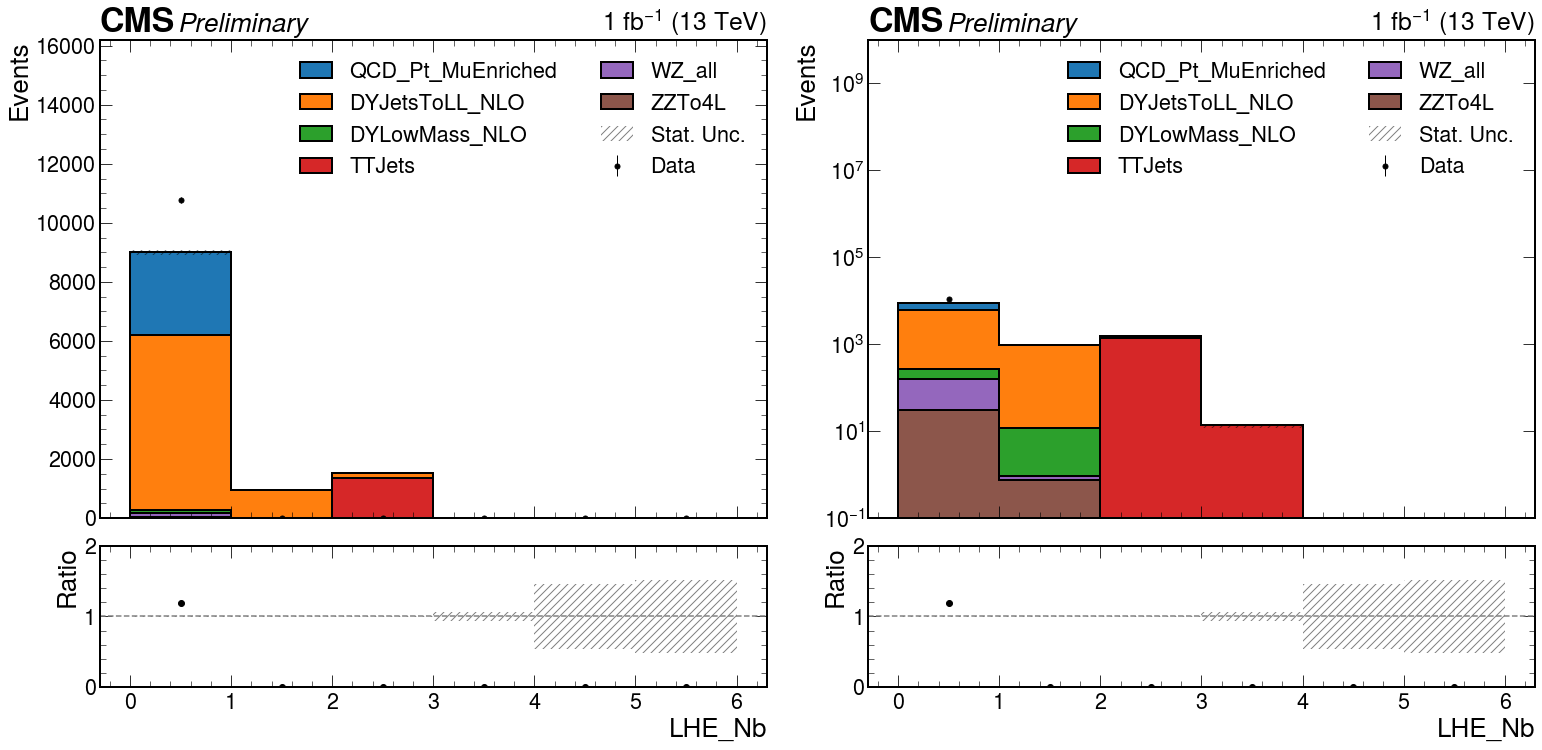

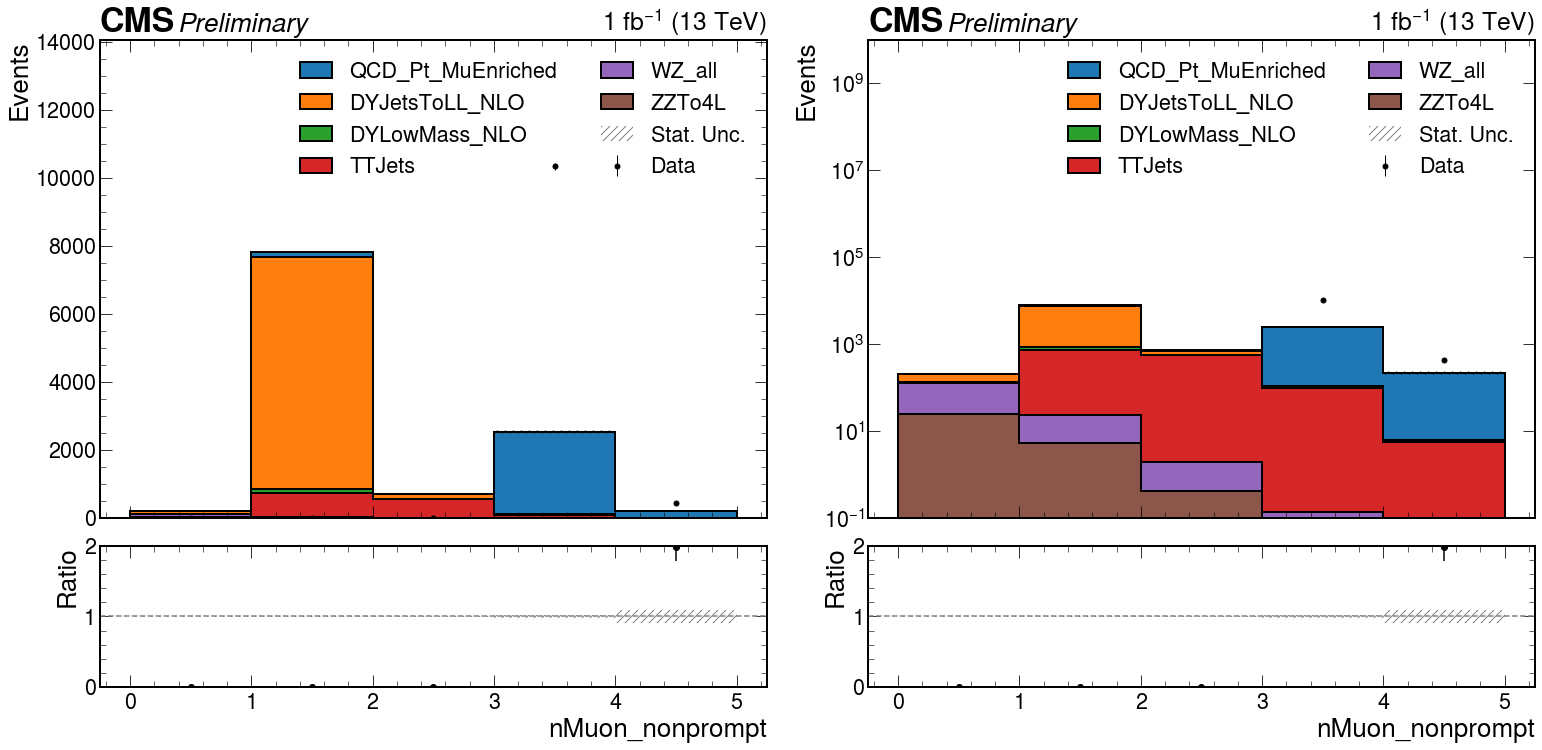

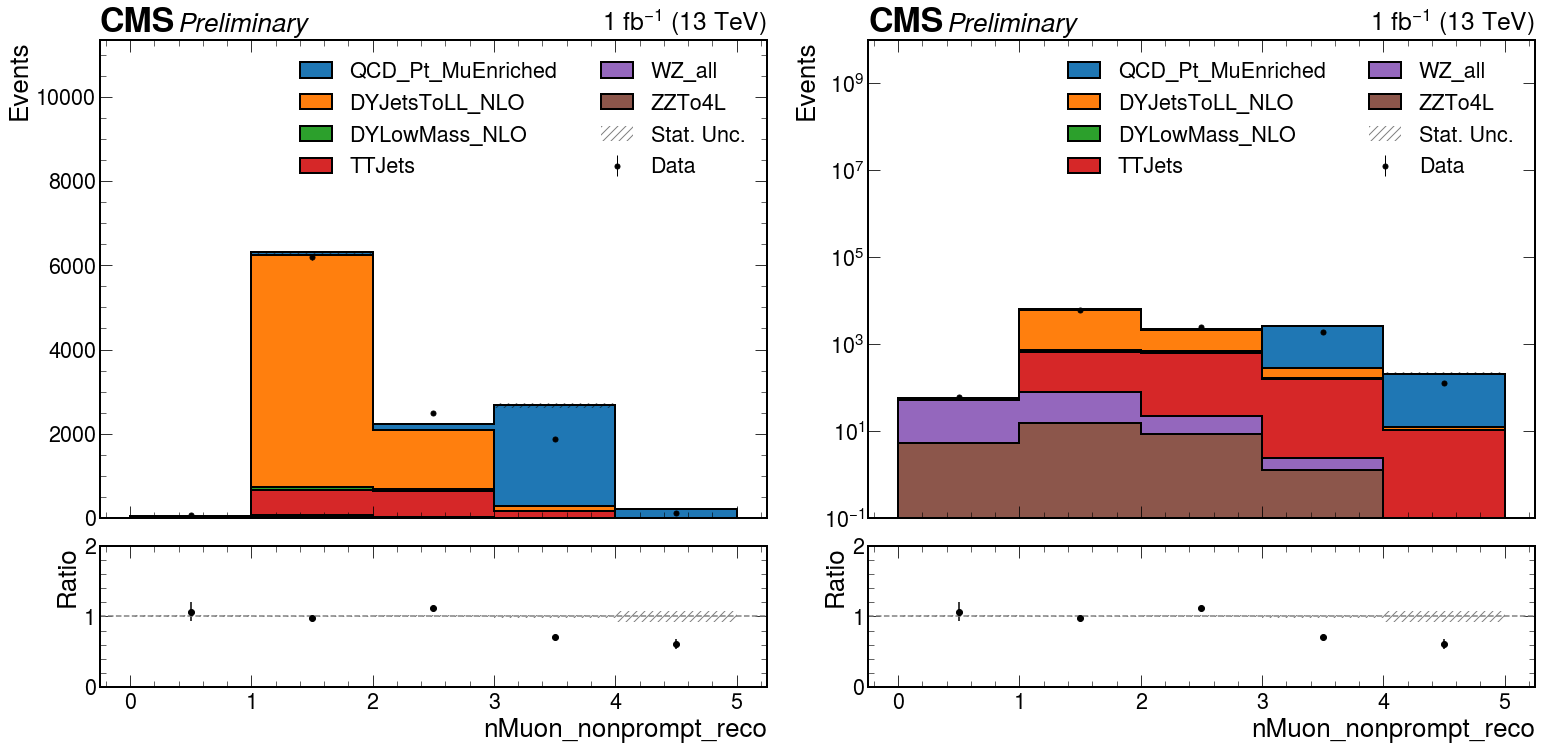

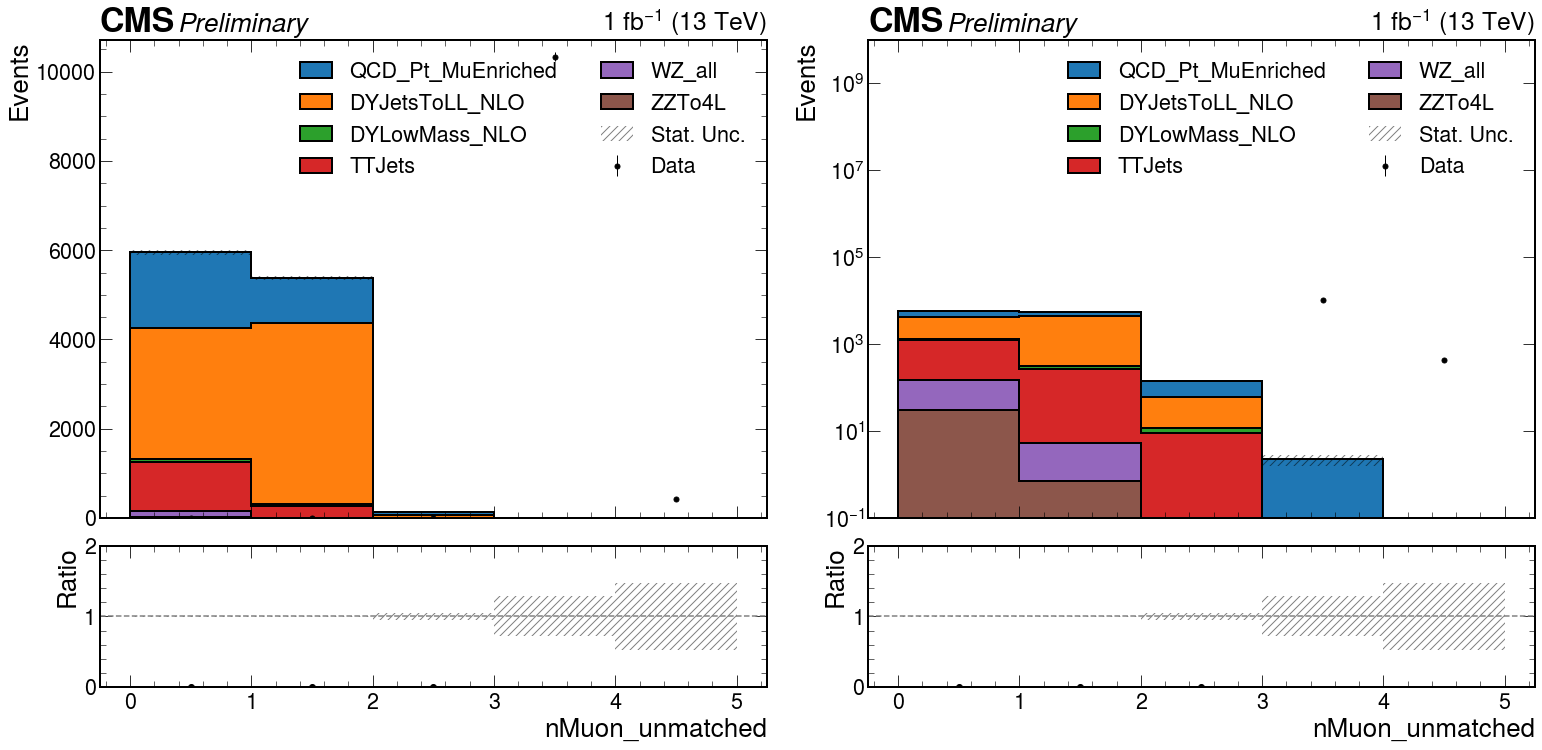

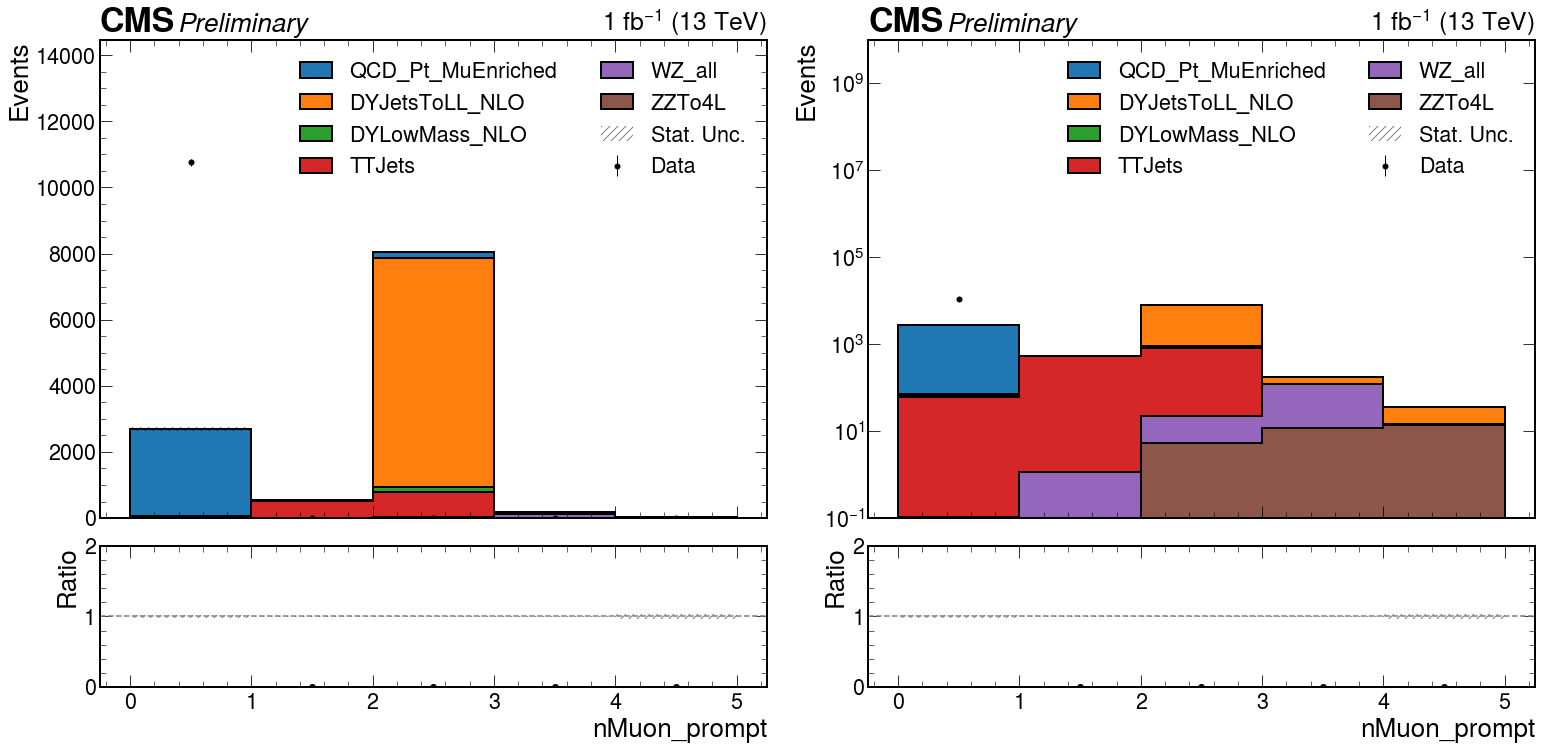

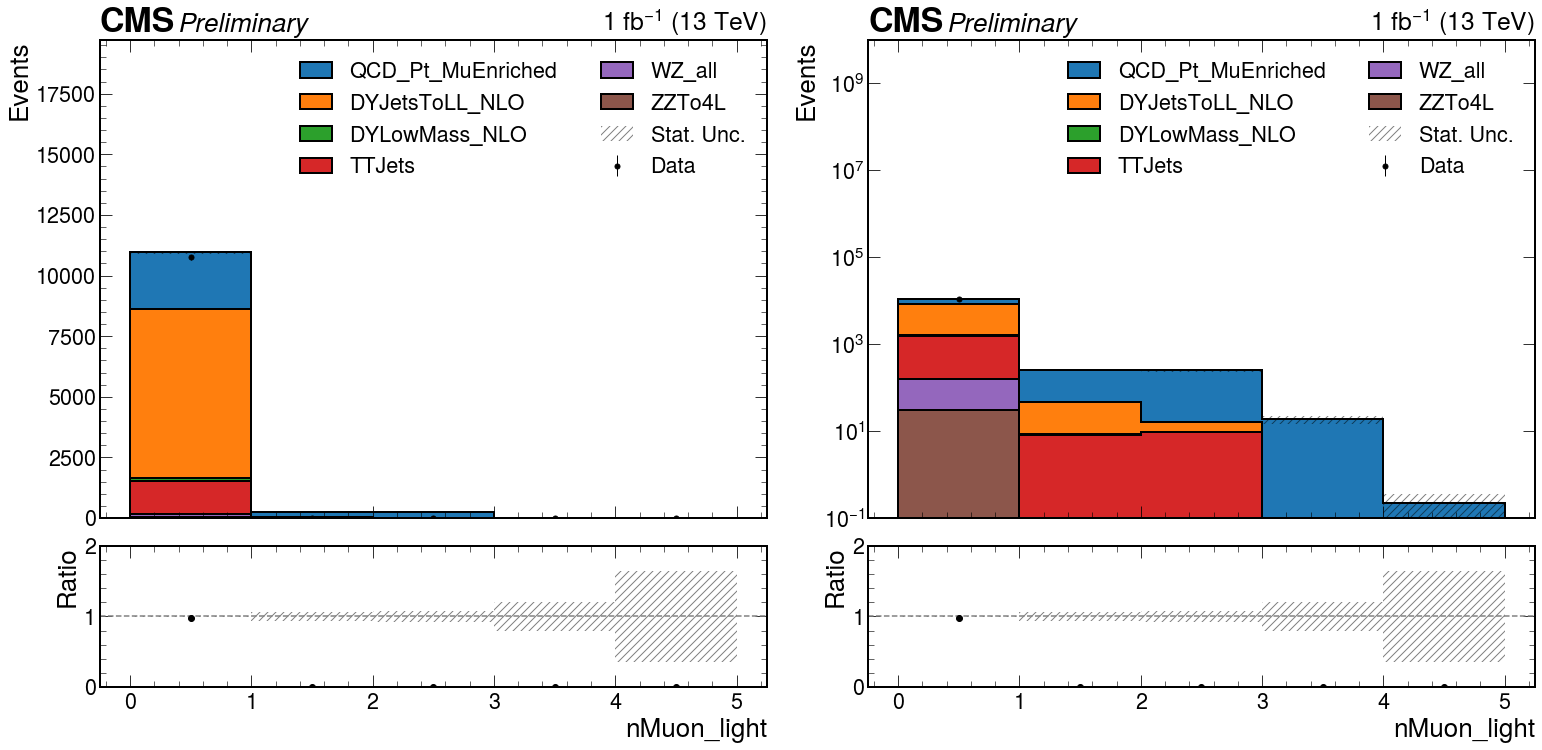

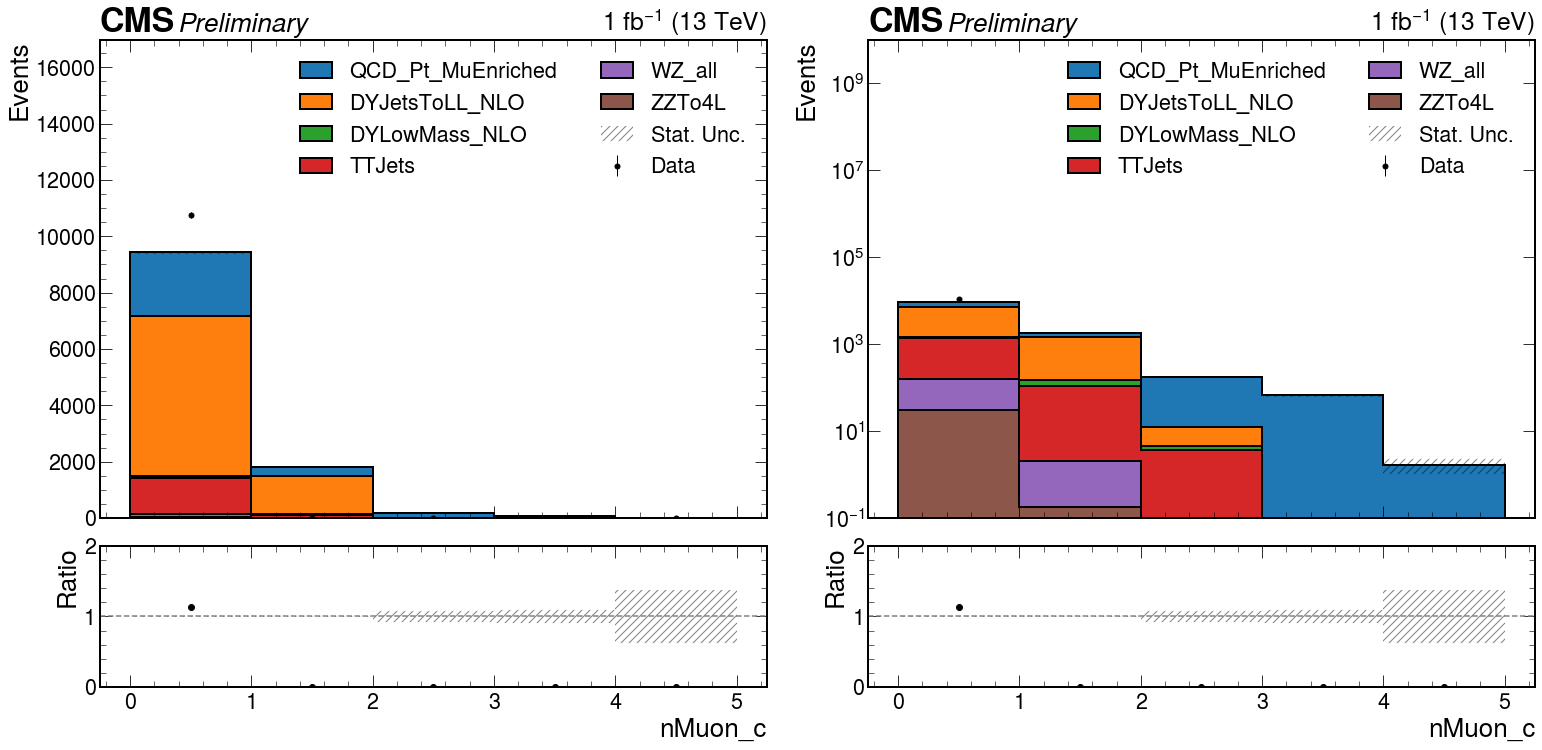

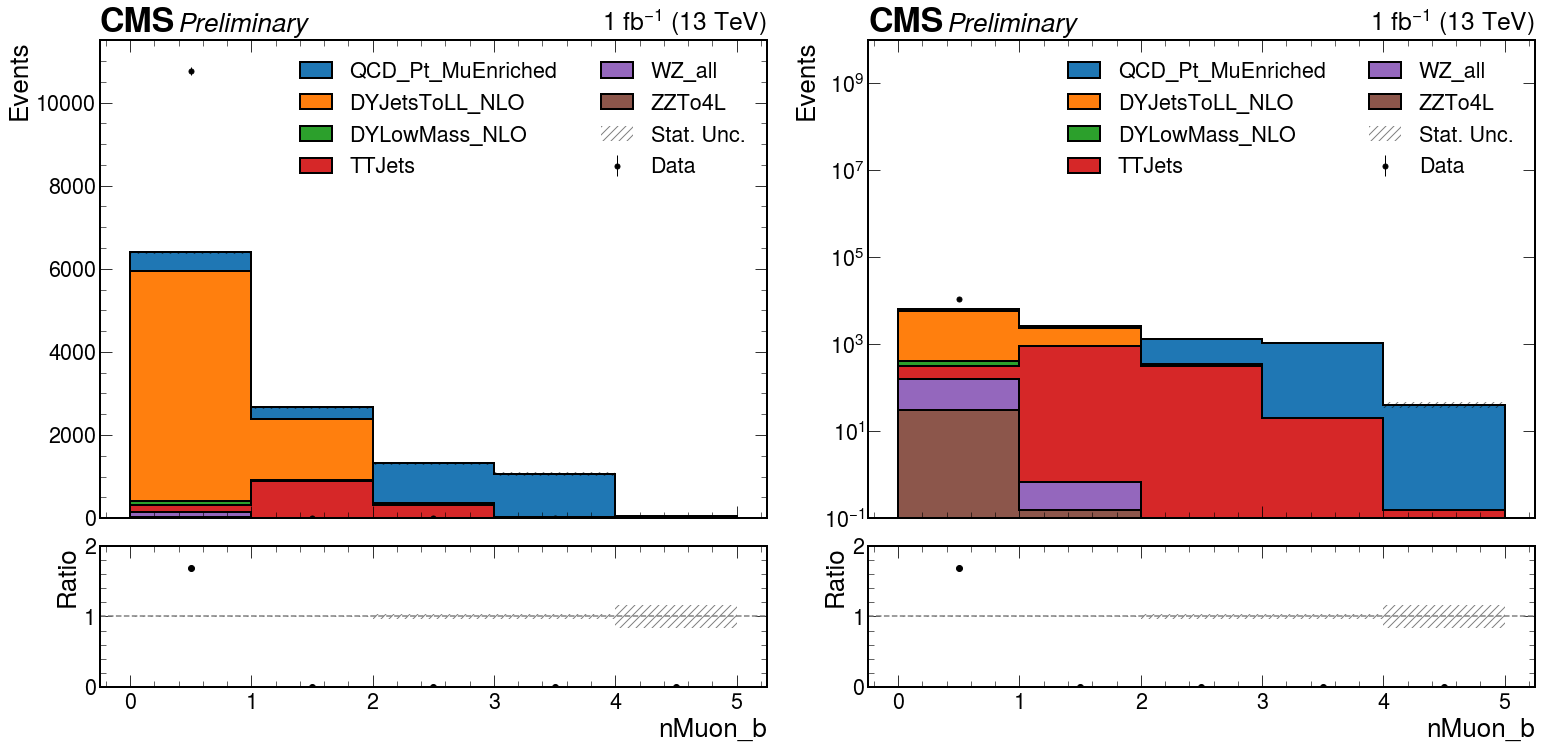

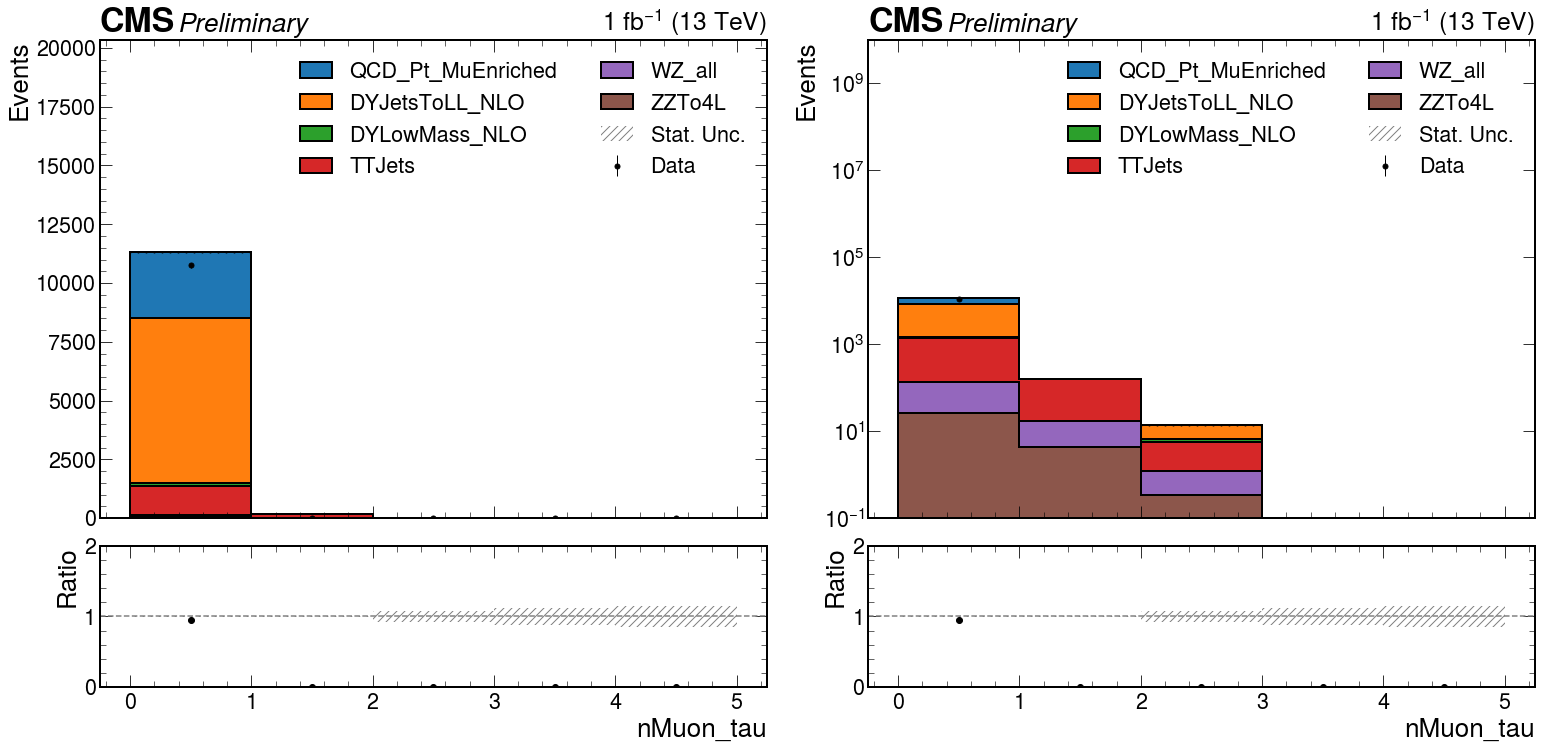

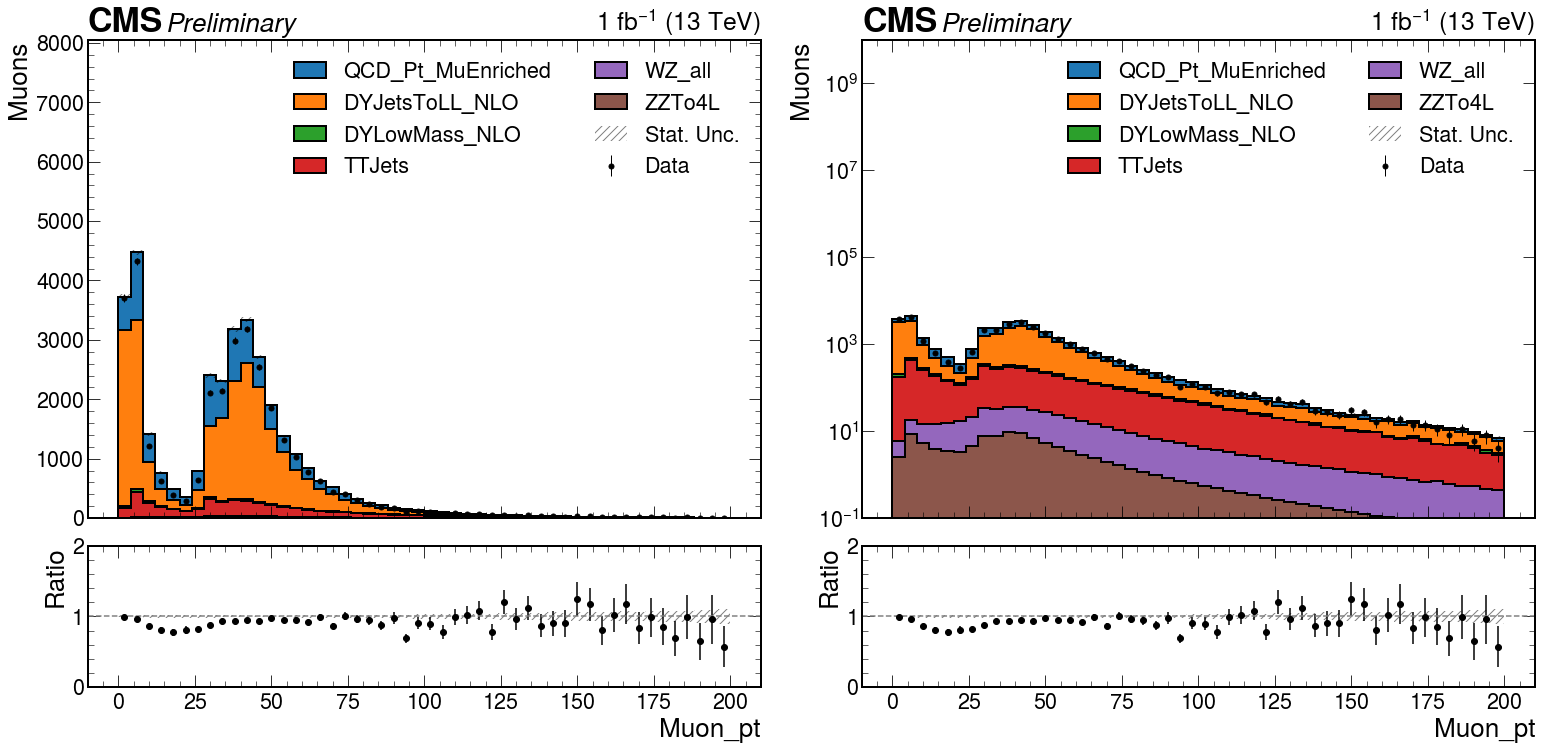

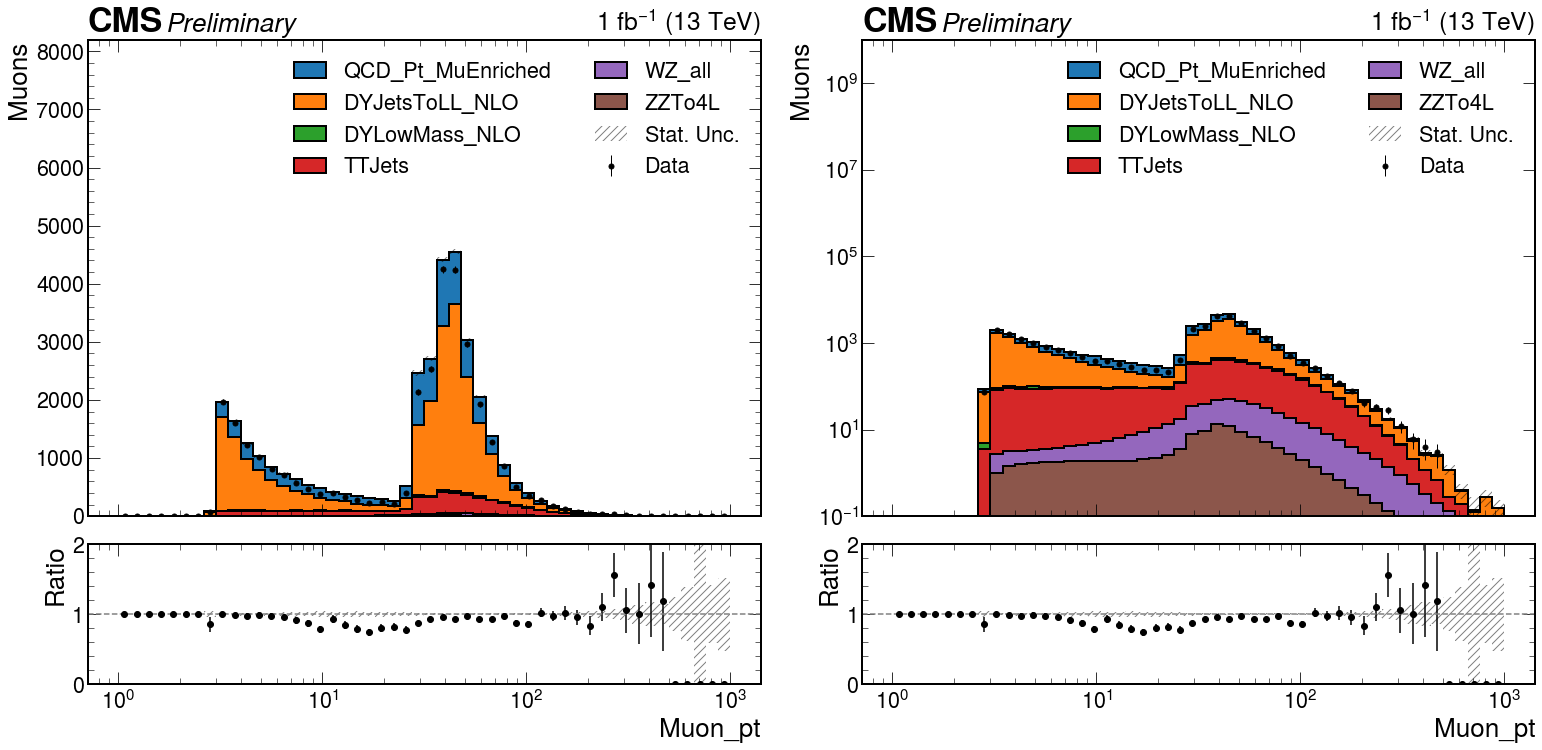

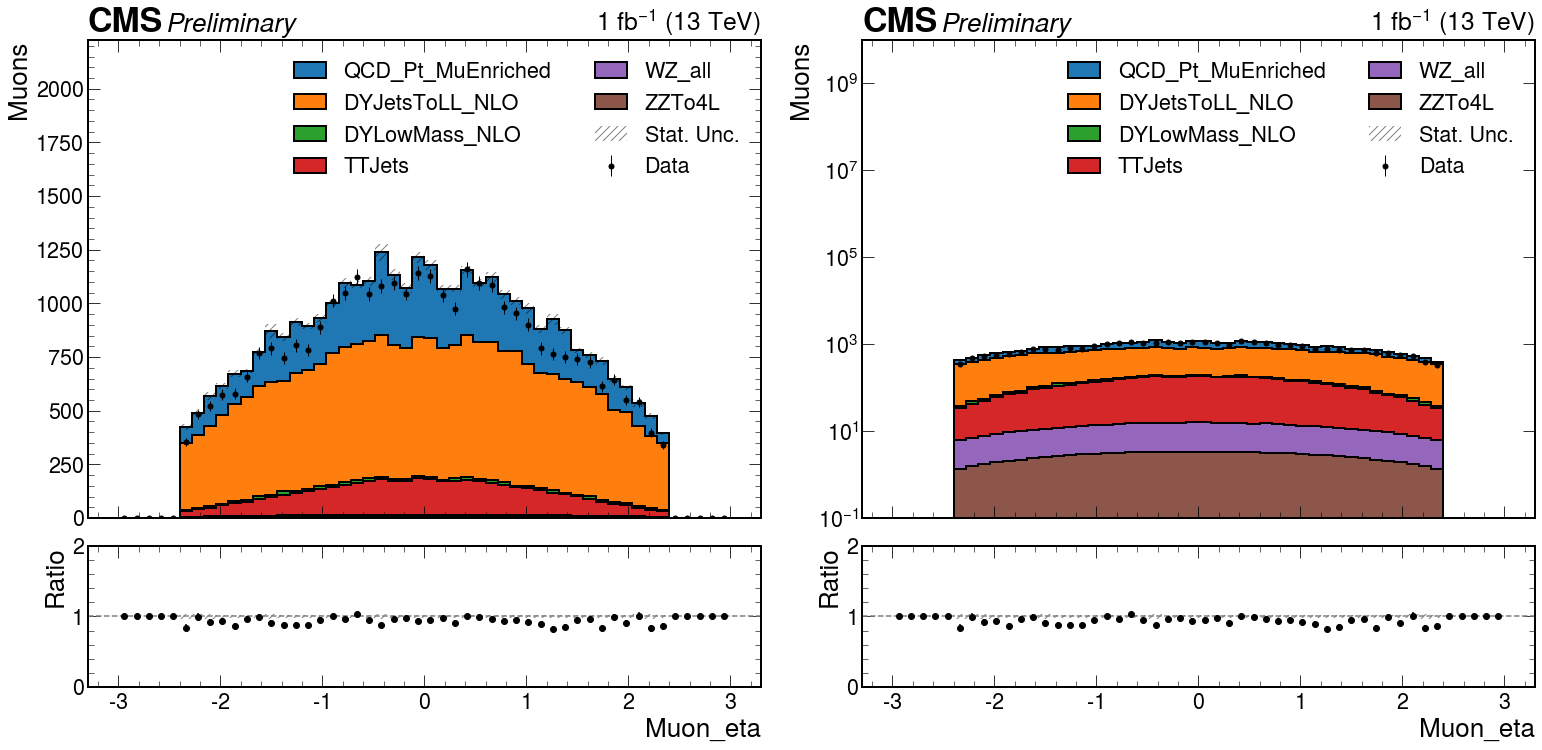

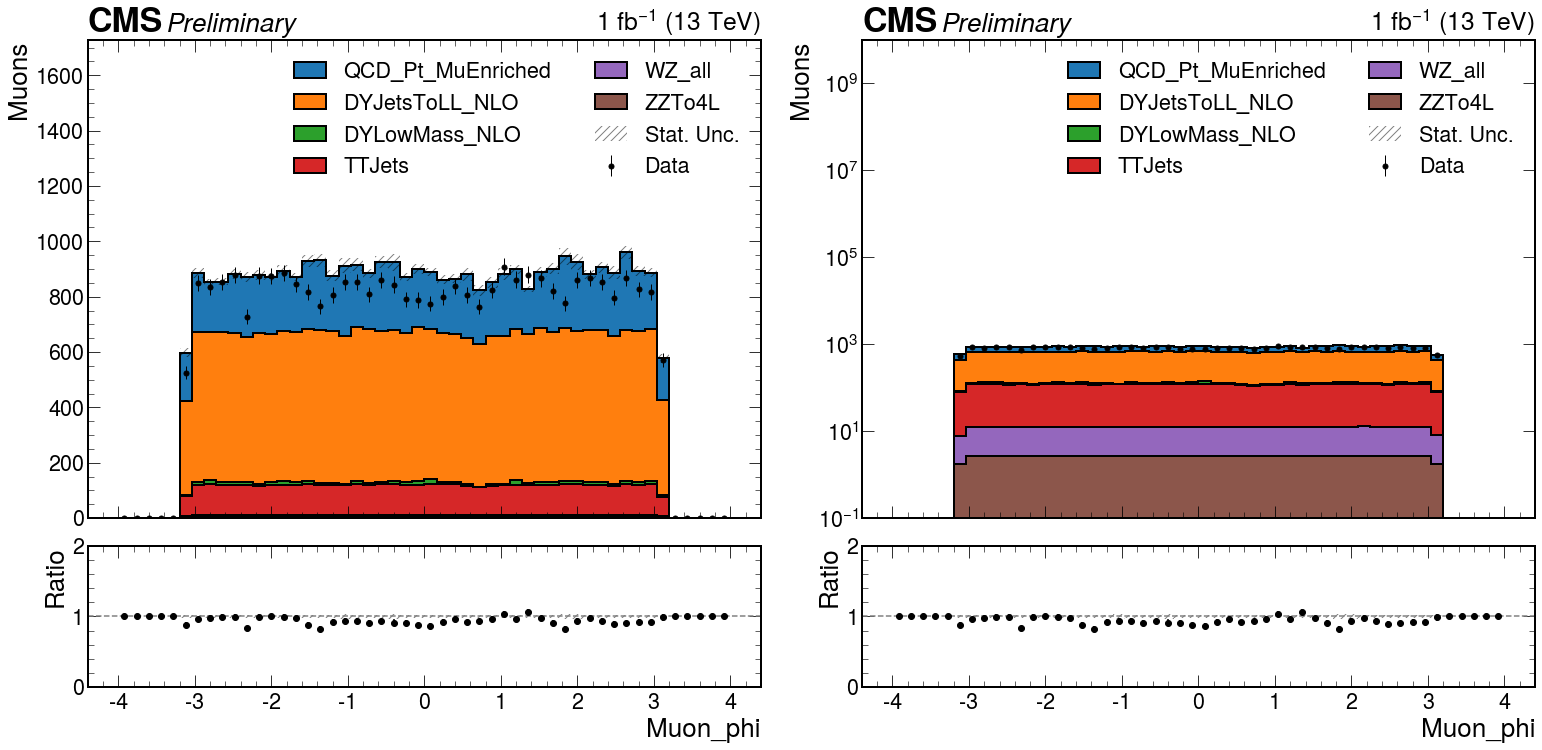

In [10]:
processes = [
    #'VVV_2018',
    #'ttZJets_2018',
    'ZZTo4L_2018',
    #'WJetsToLNu_HT_2018',
    #'WJets_inclusive_2018',
    #'WJets_all_2018',
    #'WW_all_2018', 
    'WZ_all_2018', 
    #'ST_tW_2018',
    #'ST_t-channel_2018',
    #'ST_2018',
    #'VV_2018',
    'TTJets_2018',
    #'DYCombined_2018',
    #'DYLowMass_LO_2018',
    'DYLowMass_NLO_2018',
    'DYJetsToLL_NLO_2018',
    #'DY0JetsToLL_2018',
    #'DYNJetsToLL_2018',
    'QCD_Pt_MuEnriched_2018',
    #'QCD_Pt_2018',
]
signals = [
#     'SUEP-m125-darkPho_2018',
#     'SUEP-m125-darkPhoHad_2018',
#     'SUEP-m400-darkPho_2018',
#     'SUEP-m400-darkPhoHad_2018',
]
sources = [
    'tau',
    'prompt',
    'light/other',
    'c/b',
]

plot_set = [
    [
        ('ht','ht'),
        {
            'slc': slice(10j, 1e4j),
            'xlog': True  
        }
    ],
    [
        ('ht','ht_subtracted'),
        {
            'slc': slice(10j, 1e4j),
            'xlog': True  
        }
    ],
    [
        ('nJet_vs_nGenJet_vs_nMuon','nJet'),
        {}
    ],
    [
        ('nJet_vs_nGenJet_vs_nMuon','nGenJet'),
        {}
    ],
    [
        ('nJet_vs_nGenJet_vs_nMuon','nMuon'),
        {}
    ],
    [
        ('LHE_Njets_vs_Nglu_vs_Nuds_vs_Nc_vs_Nb_vs_nMuon','LHE_Njets'),
        {}
    ],
    [
        ('LHE_Njets_vs_Nglu_vs_Nuds_vs_Nc_vs_Nb_vs_nMuon','LHE_Nb'),
        {}
    ],
    [
        ('LHE_Njets_vs_nMuon_vs_nMuon_nonprompt_vs_nMuon_nonprompt_reco','nMuon_nonprompt'),
        {}
    ],
    [
        ('LHE_Njets_vs_nMuon_vs_nMuon_nonprompt_vs_nMuon_nonprompt_reco','nMuon_nonprompt_reco'),
        {}
    ],
    [
        (
            'nMuon_unmatched_vs_nMuon_prompt_vs_nMuon_light_vs_nMuon_c_vs_nMuon_b_vs_nMuon_tau',
            'nMuon_unmatched'
        ),
        {}
    ],
    [
        (
            'nMuon_unmatched_vs_nMuon_prompt_vs_nMuon_light_vs_nMuon_c_vs_nMuon_b_vs_nMuon_tau',
            'nMuon_prompt'
        ),
        {}
    ],
    [
        (
            'nMuon_unmatched_vs_nMuon_prompt_vs_nMuon_light_vs_nMuon_c_vs_nMuon_b_vs_nMuon_tau',
            'nMuon_light'
        ),
        {}
    ],
    [
        (
            'nMuon_unmatched_vs_nMuon_prompt_vs_nMuon_light_vs_nMuon_c_vs_nMuon_b_vs_nMuon_tau',
            'nMuon_c'
        ),
        {}
    ],
    [
        (
            'nMuon_unmatched_vs_nMuon_prompt_vs_nMuon_light_vs_nMuon_c_vs_nMuon_b_vs_nMuon_tau',
            'nMuon_b'
        ),
        {}
    ],
    [
        (
            'nMuon_unmatched_vs_nMuon_prompt_vs_nMuon_light_vs_nMuon_c_vs_nMuon_b_vs_nMuon_tau',
            'nMuon_tau'
        ),
        {}
    ],
    [
        ('muon_pt_linear_vs_genPartFlav_vs_nMuon','Muon_pt'),
        {
            'per_muon': True
        }
    ],
    [
        ('muon_pt_vs_genPartFlav_vs_nMuon','Muon_pt'),
        {
            'xlog': True,
            'per_muon': True
        }
    ],
    [
        ('muon_eta_vs_genPartFlav_vs_nMuon','Muon_eta'),
        {
            'per_muon': True
        }
    ],
    [
        ('muon_phi_vs_genPartFlav_vs_nMuon','Muon_phi'),
        {
            'per_muon': True
        }
    ],
    """
    [
        ('muon_miniPFRelIso_vs_genPartFlav_vs_nMuon','Muon_miniPFRelIso_all'), 
        {
            'slc': slice(0, 0.1j, 2j),
            'xlog': True
        }
    ],
    [
        ('muon_dxy_vs_genPartFlav_vs_nMuon','Muon_dxy'),
        {
            'slc': slice(0, 0.003j, 2j),
            'xlog': True
        }
    ],
    [
        ('muon_dz_vs_genPartFlav_vs_nMuon','Muon_dz'),
        {
            'slc': slice(0, 0.01j, 2j),
            'xlog': True
        }
    ],
    [
        ('muon_btagDeepFlavB_vs_genPartFlav_vs_nMuon','matched_jet_btagDeepFlavB'),
        {'xlog': False}
    ],
    [
        ('muon_matched_jetPtRelv2_vs_genPartFlav_vs_nMuon','matched_jetPtRelv2'),
        {
            'slc': slice(None, None, 2j),
            'xlog': True
        }
    ],
    [
        ('muon_matched_jetRelIso_vs_genPartFlav_vs_nMuon','matched_jetRelIso'),
        {
            'slc': slice(None, None, 2j),
            'xlog': True
        }
    ],
    """
]


for plot_i in plot_set:
    if plot_i[0][0] not in plots[processes[0]].keys():
        continue

    # Stack with ratio for processes
    fig = plt.figure(figsize=(22, 11))
    G = gridspec.GridSpec(4, 2, figure=fig)
    left_gs = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=G[:, 0])
    right_gs = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=G[:, 1])
    plot_utils.plot_ratio_stack(
        plots=plots, 
        bkg_list=processes, 
        sig_list=signals,
        label=plot_i[0],
        ylog=False,
        override_slice=True,
        fig=fig,
        gs=left_gs,
        **plot_i[1]
    )
    plot_utils.plot_ratio_stack(
        plots=plots, 
        bkg_list=processes, 
        sig_list=signals,
        label=plot_i[0],
        ylog=True,
        override_slice=True,
        fig=fig,
        gs=right_gs,
        **plot_i[1]
    )
    plt.tight_layout()
    plt.show()

    """    
    # Stack with ratio for sources
    fig = plt.figure(figsize=(20, 10))
    G = gridspec.GridSpec(4, 2, figure=fig)
    left_gs = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=G[:, 0])
    right_gs = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=G[:, 1])
    plot_utils.plot_ratio_stack(
        plots=plots, 
        bkg_list=sources, 
        sig_list=signals,
        label=plot_i[0],
        ylog=False,
        override_slice=True,
        fig=fig,
        gs=left_gs,
        per_muon=True,
        **plot_i[1]
    )
    plot_utils.plot_ratio_stack(
        plots=plots, 
        bkg_list=sources, 
        sig_list=signals,
        label=plot_i[0],
        ylog=True,
        override_slice=True,
        fig=fig,
        gs=right_gs,
        per_muon=True,
        **plot_i[1]
    )
    plt.tight_layout()
    plt.show()

    # Overlay for processes
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(22, 11))
    plot_utils.plot_overlay(
        plots=plots, 
        bkg_list=processes, 
        label=plot_i[0], 
        override_slice=True,
        fig=fig,
        ax=ax[0],
        per_muon=True,
        **plot_i[1]
    )
    plot_utils.plot_overlay(
        plots=plots, 
        bkg_list=processes, 
        label=plot_i[0], 
        override_slice=True,
        fig=fig,
        ax=ax[1],
        ylog=True,
        per_muon=True,
        **plot_i[1]
    )
    plt.tight_layout()
    plt.show()

    # Overlay for sources
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(22, 11))
    plot_utils.plot_overlay(
        plots=plots, 
        bkg_list=sources, 
        label=plot_i[0], 
        override_slice=True,
        fig=fig,
        ax=ax[0],
        per_muon=True,
        **plot_i[1]
    )
    plot_utils.plot_overlay(
        plots=plots, 
        bkg_list=sources, 
        label=plot_i[0], 
        override_slice=True,
        fig=fig,
        ax=ax[1],
        ylog=True,
        per_muon=True,
        **plot_i[1]
    )
    plt.tight_layout()
    plt.show()
    """

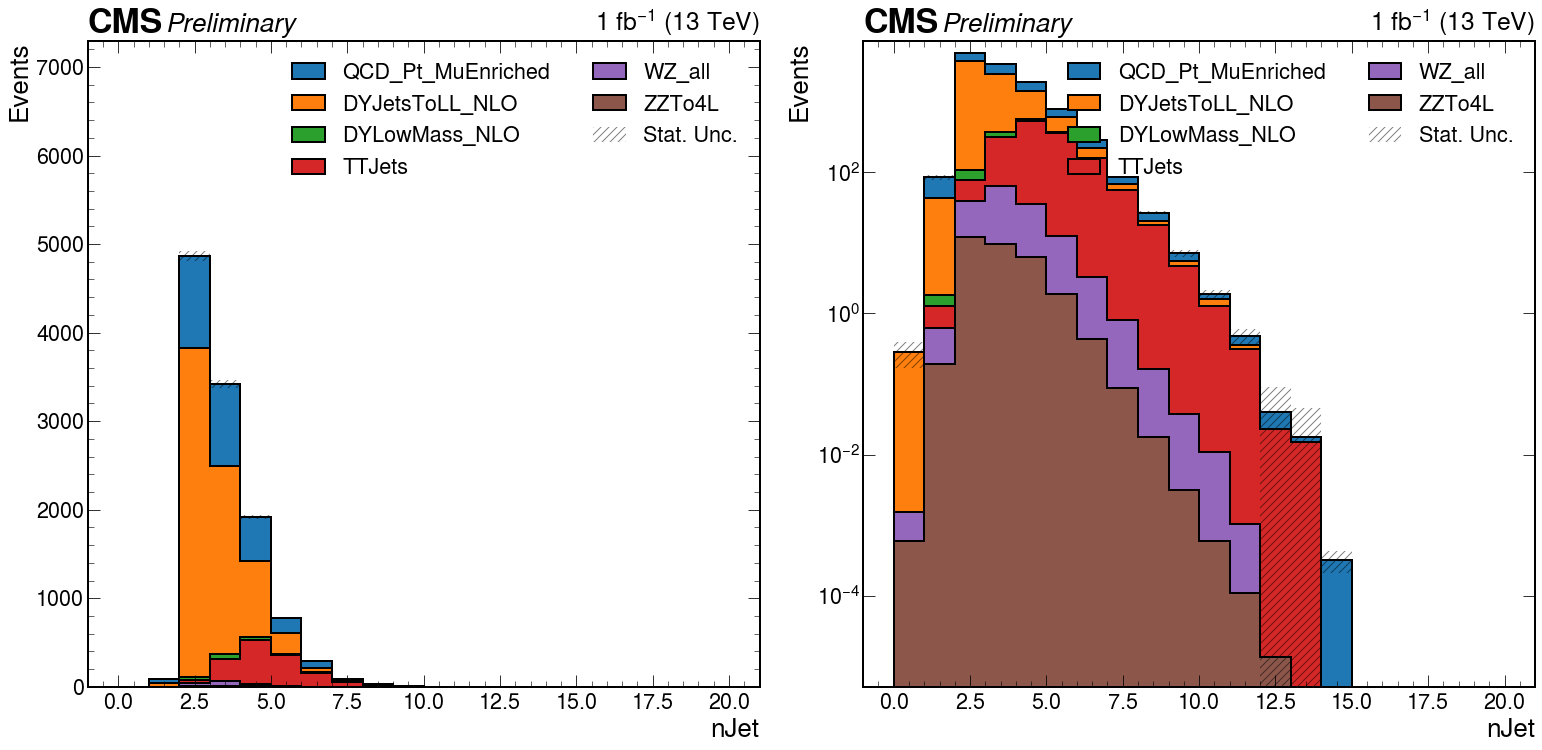

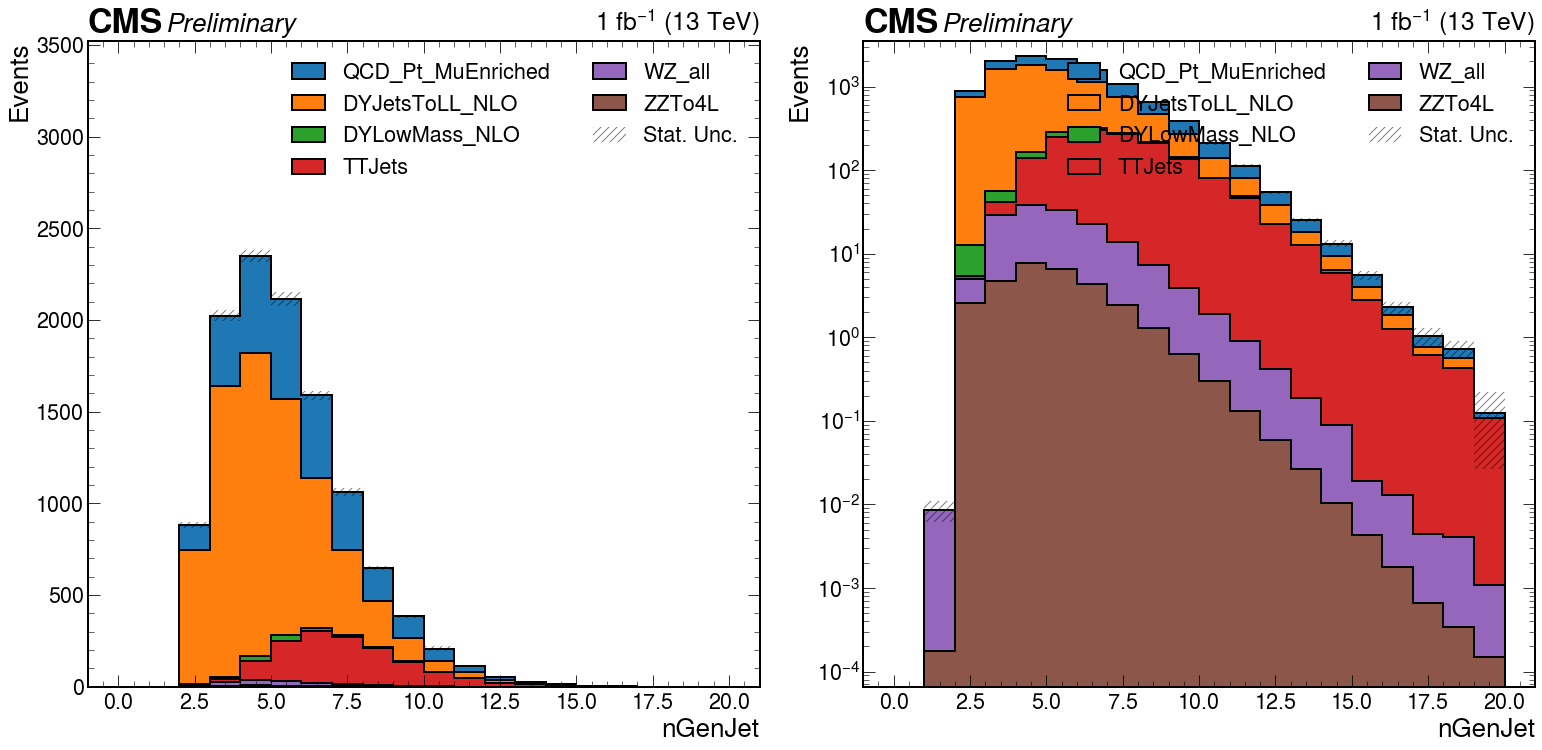

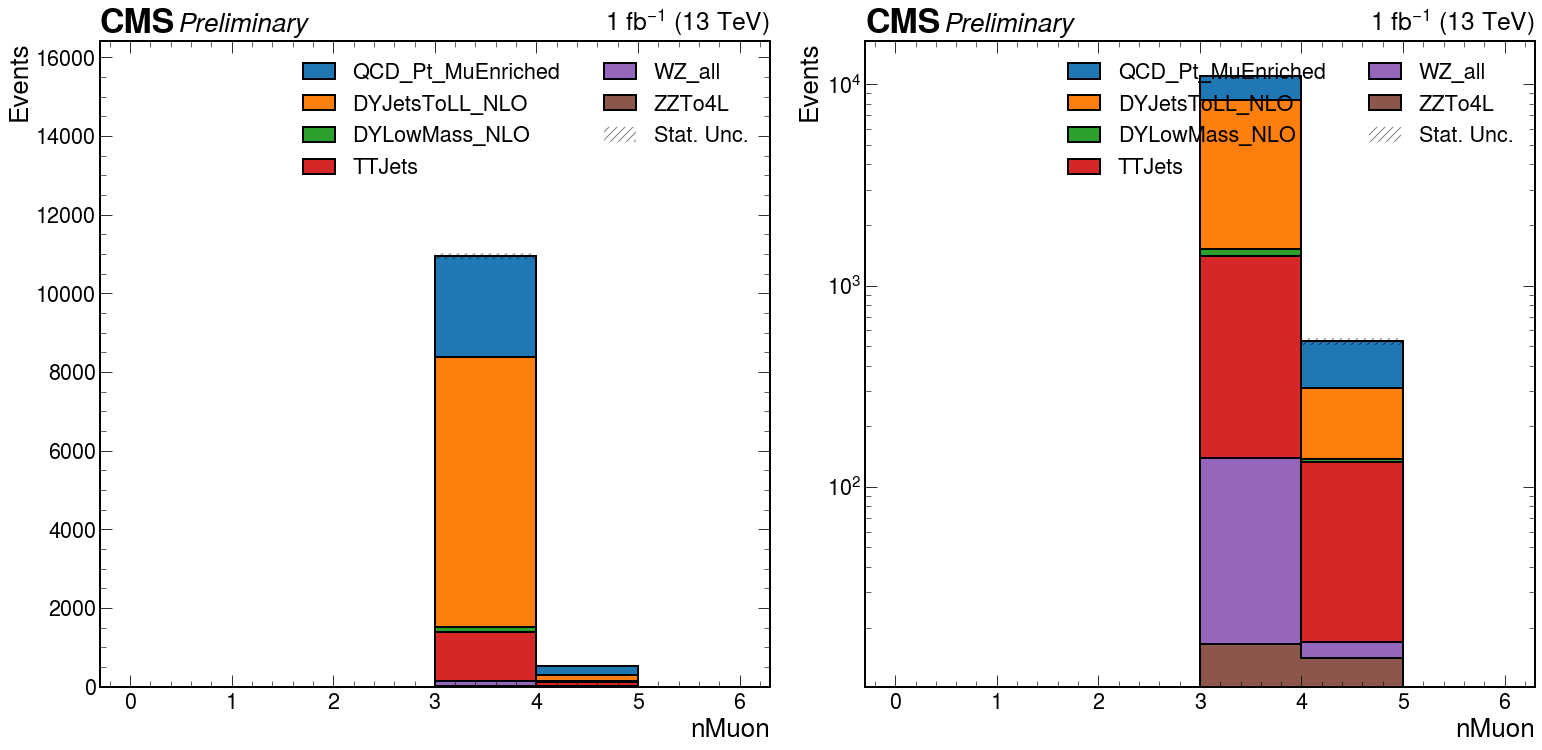

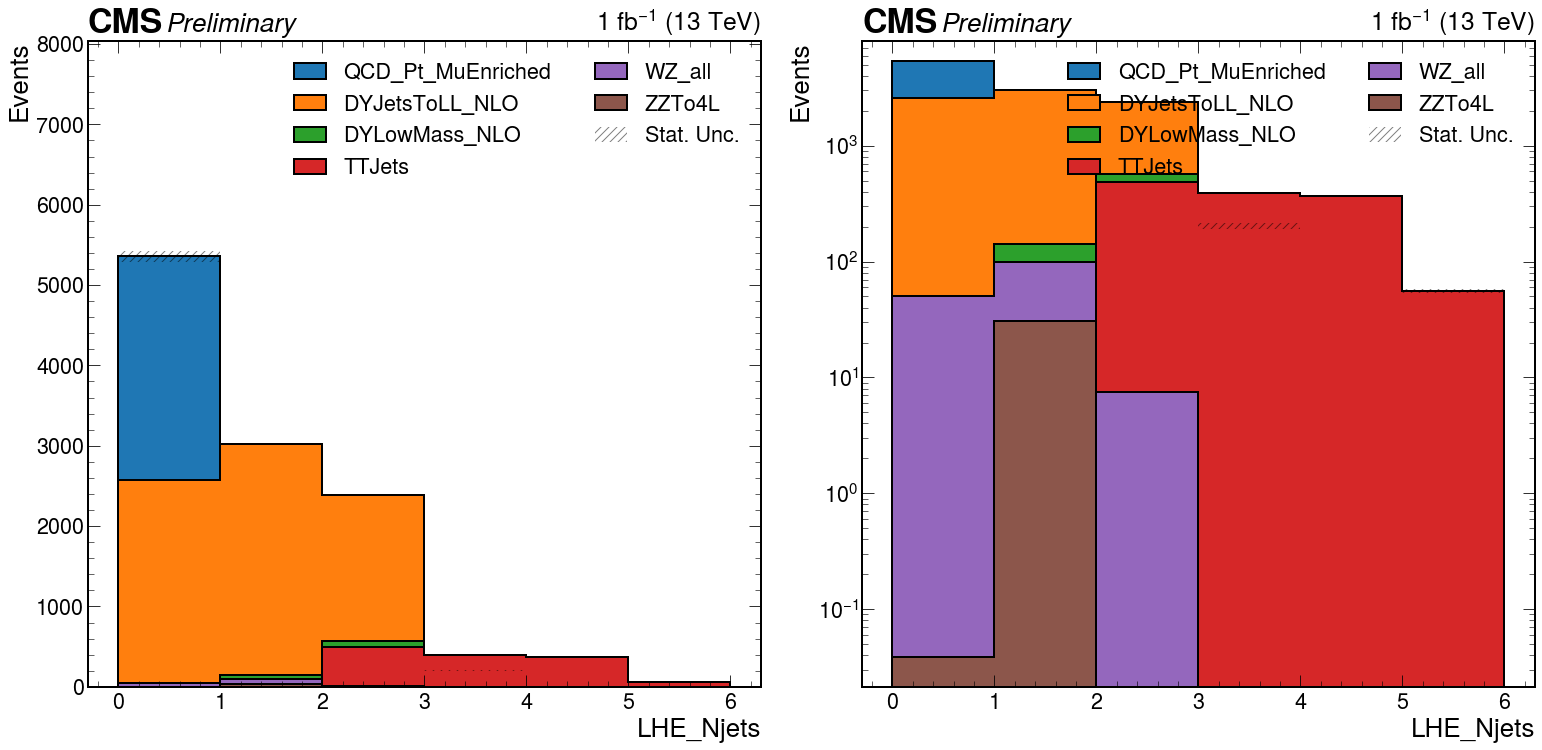

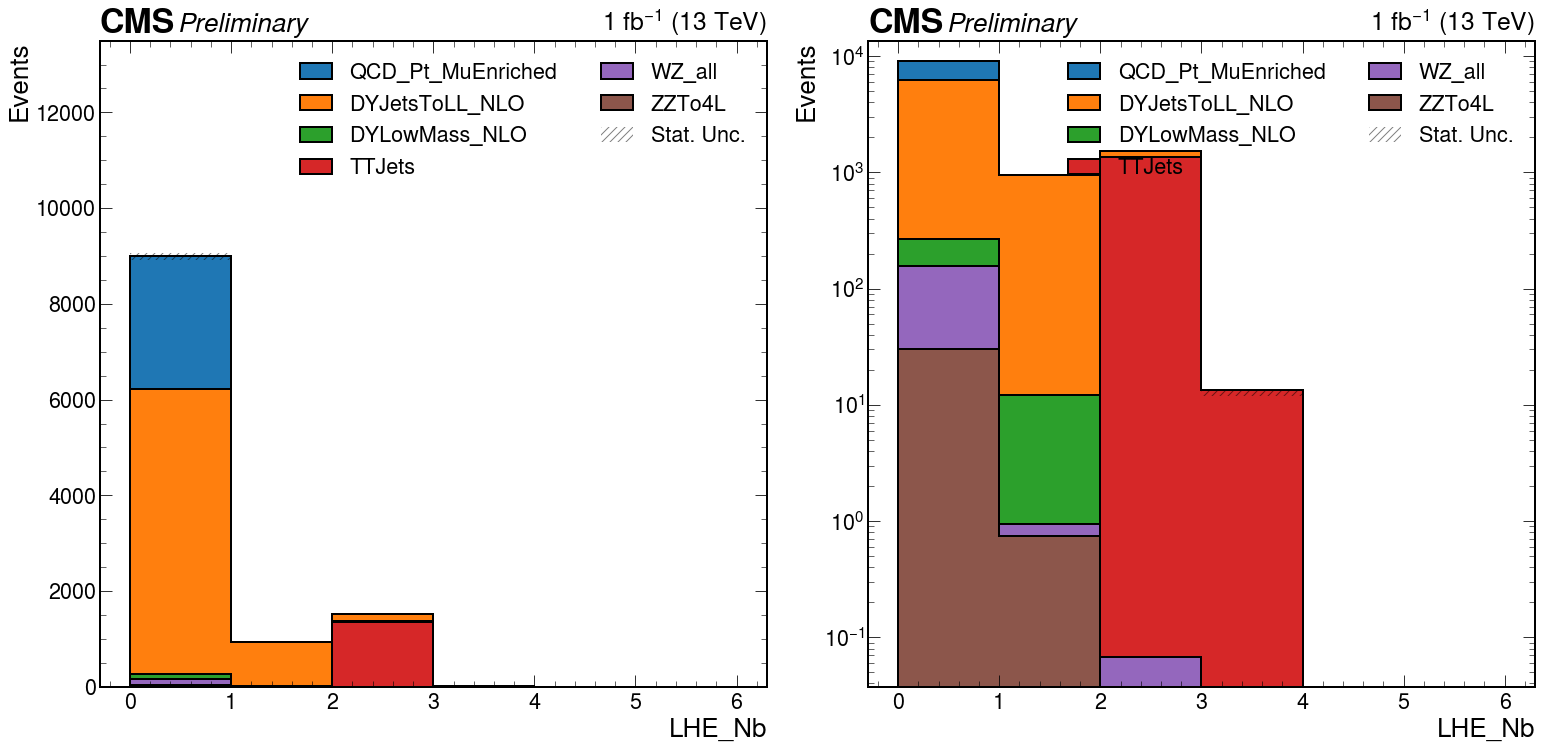

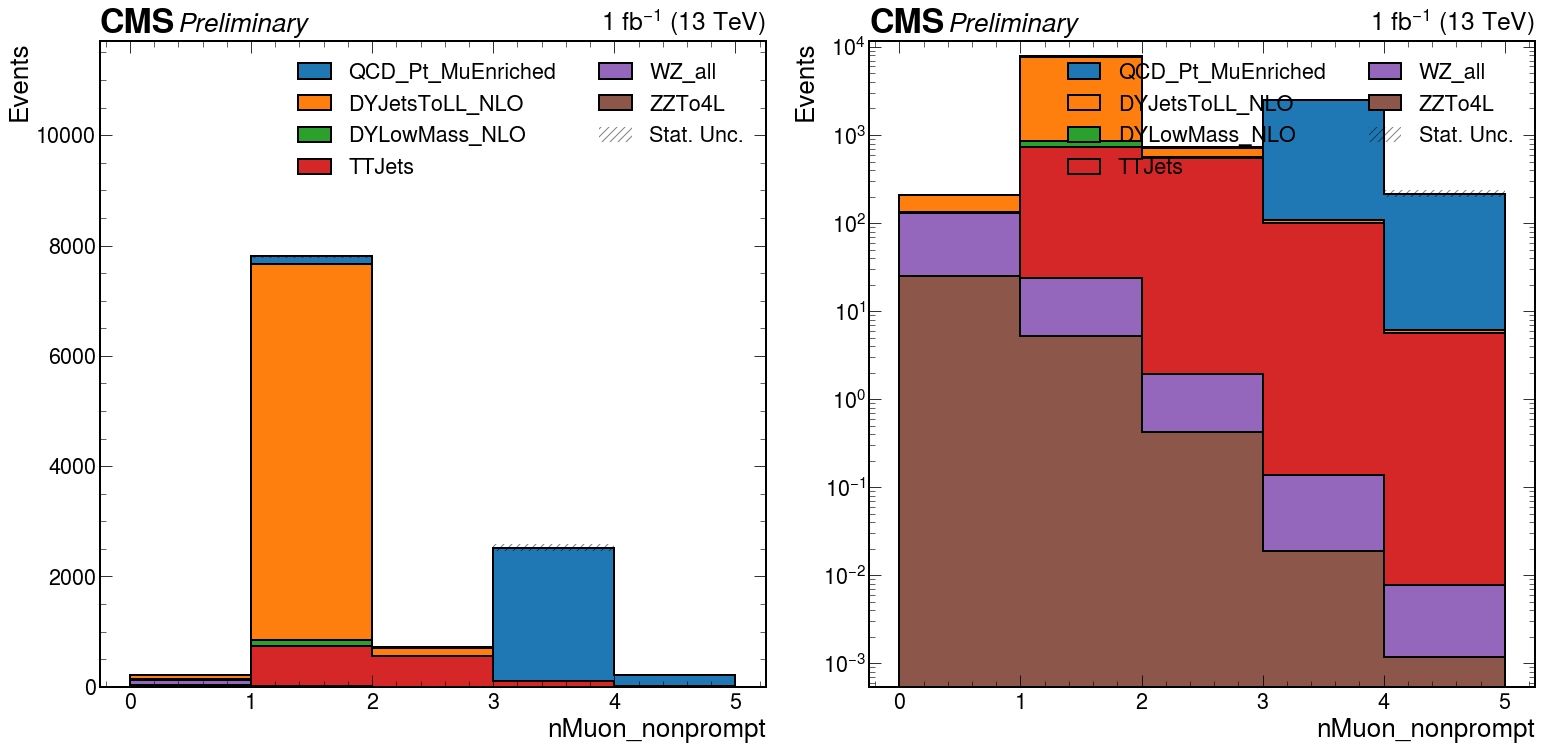

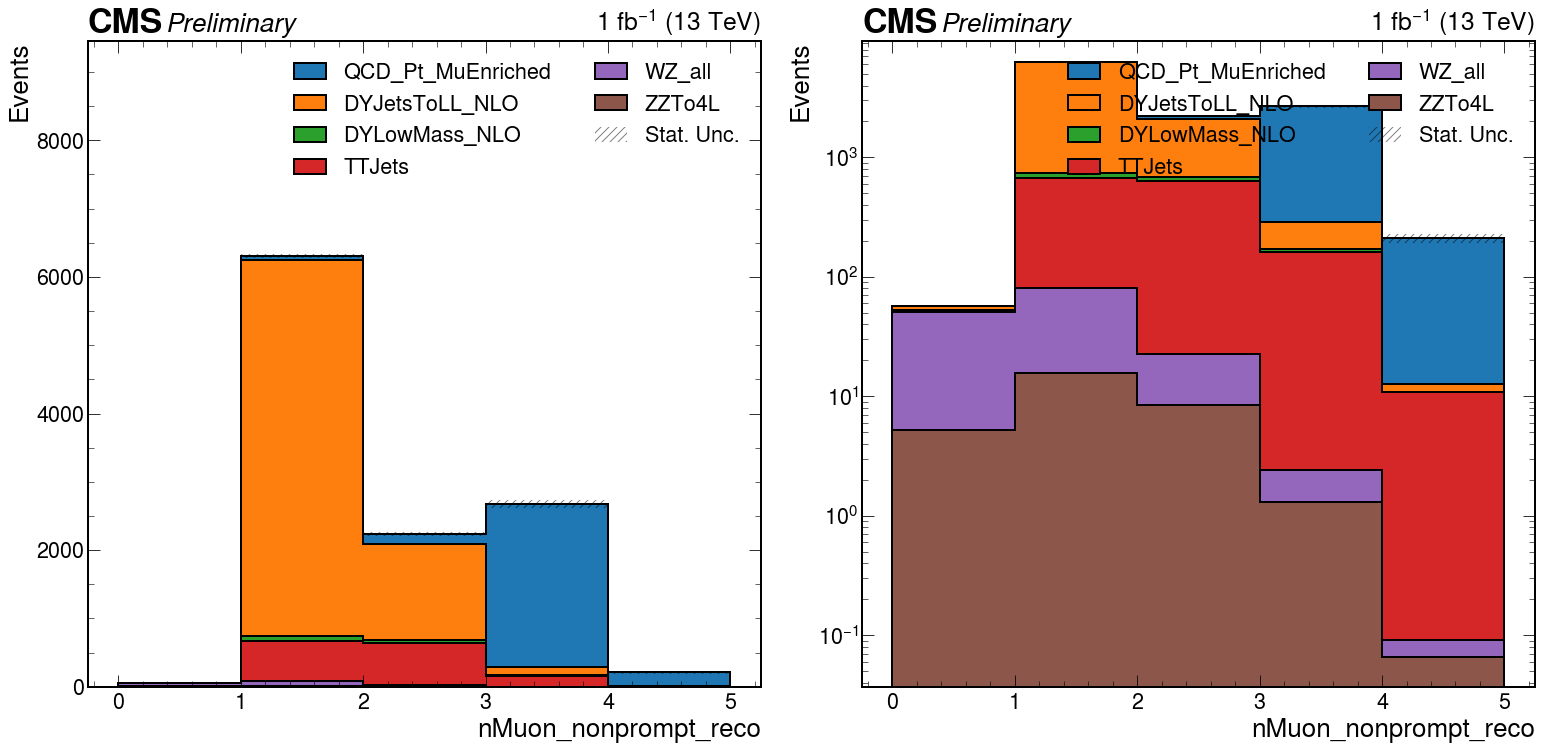

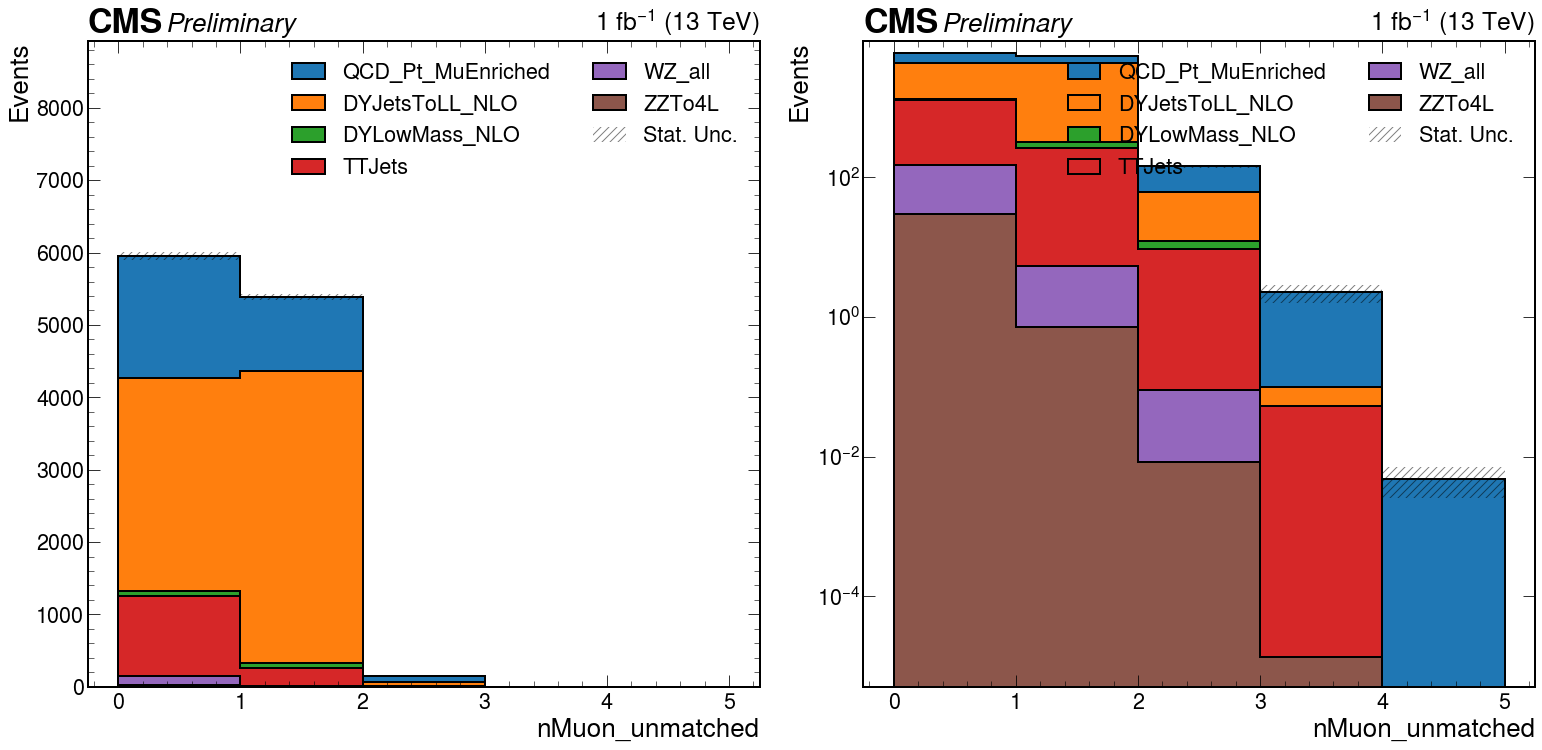

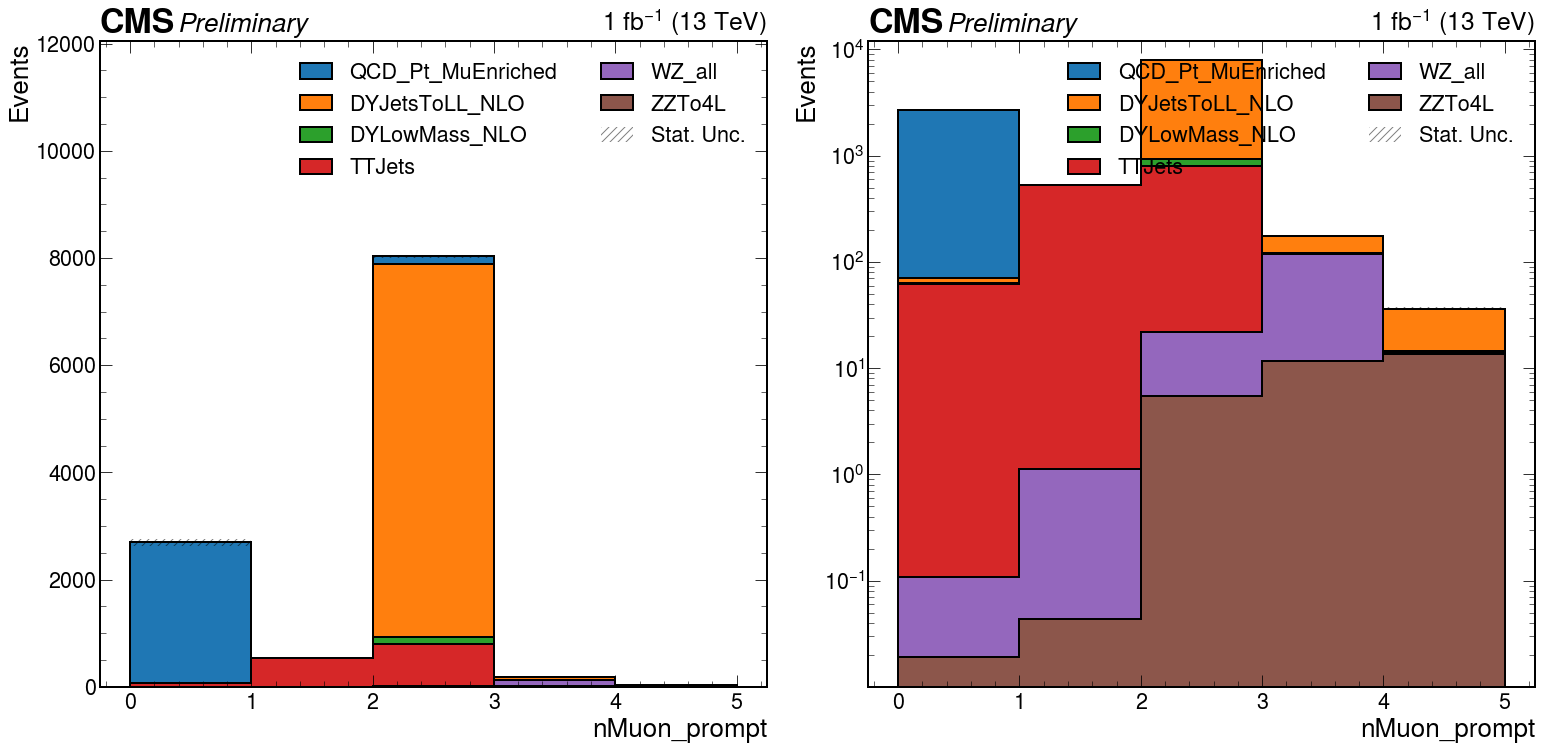

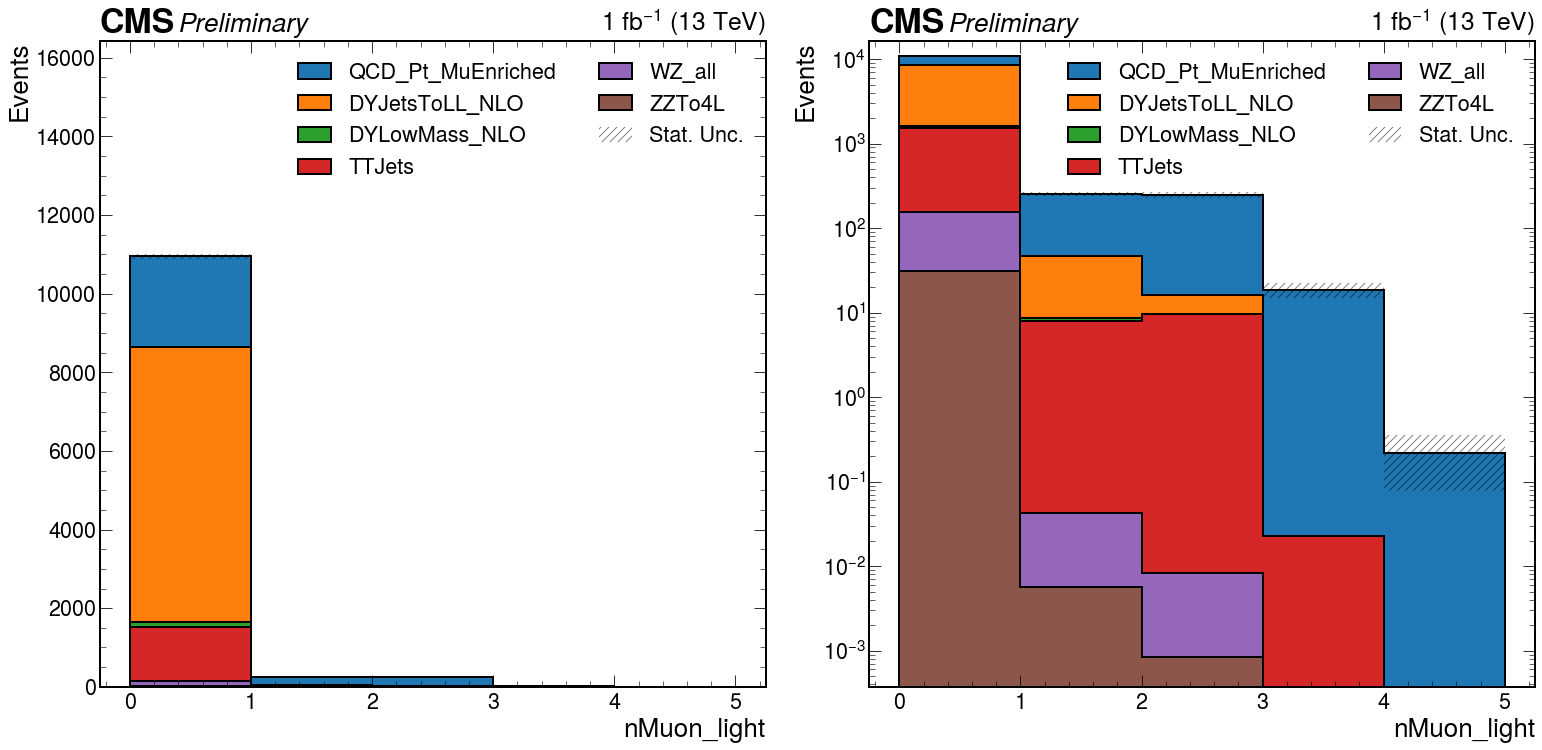

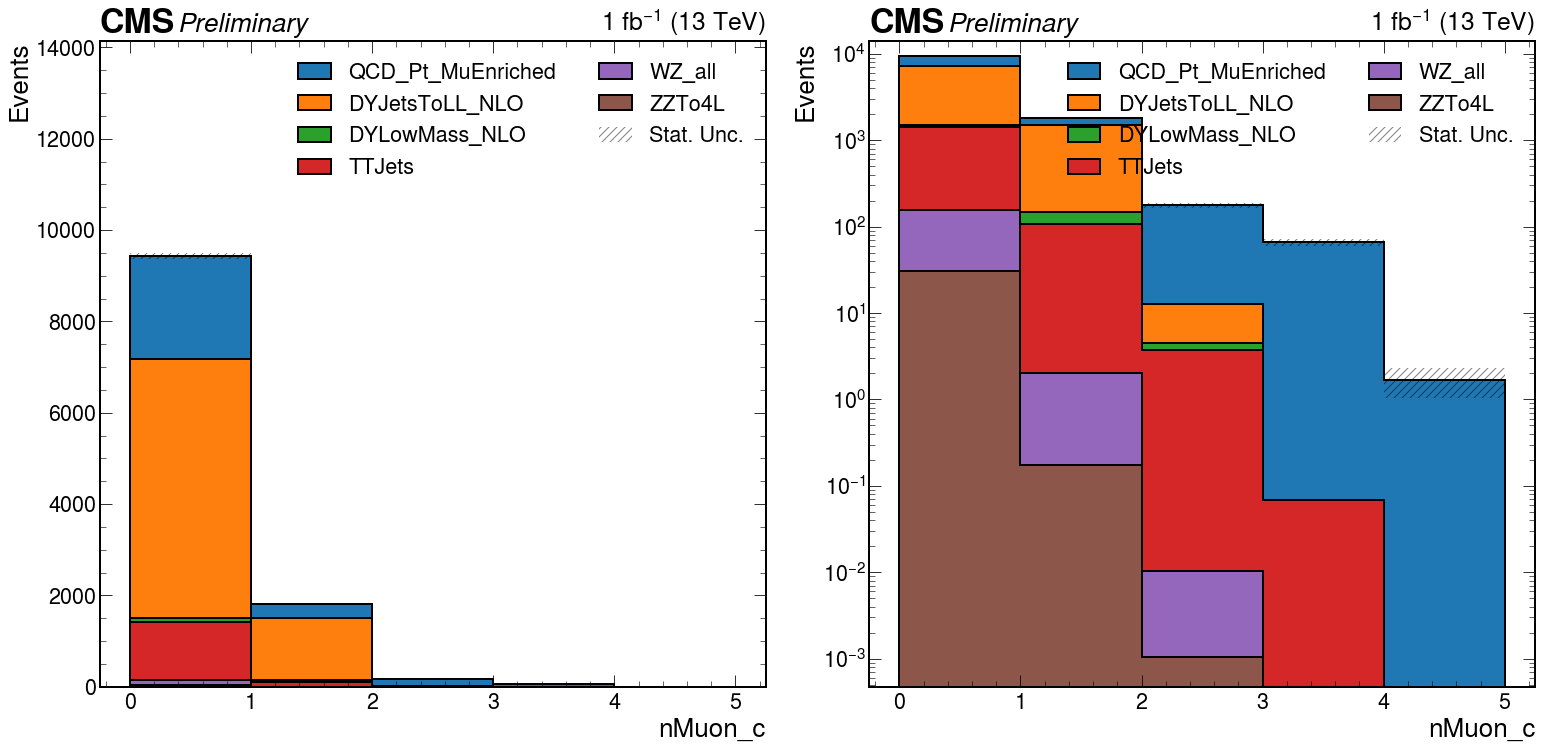

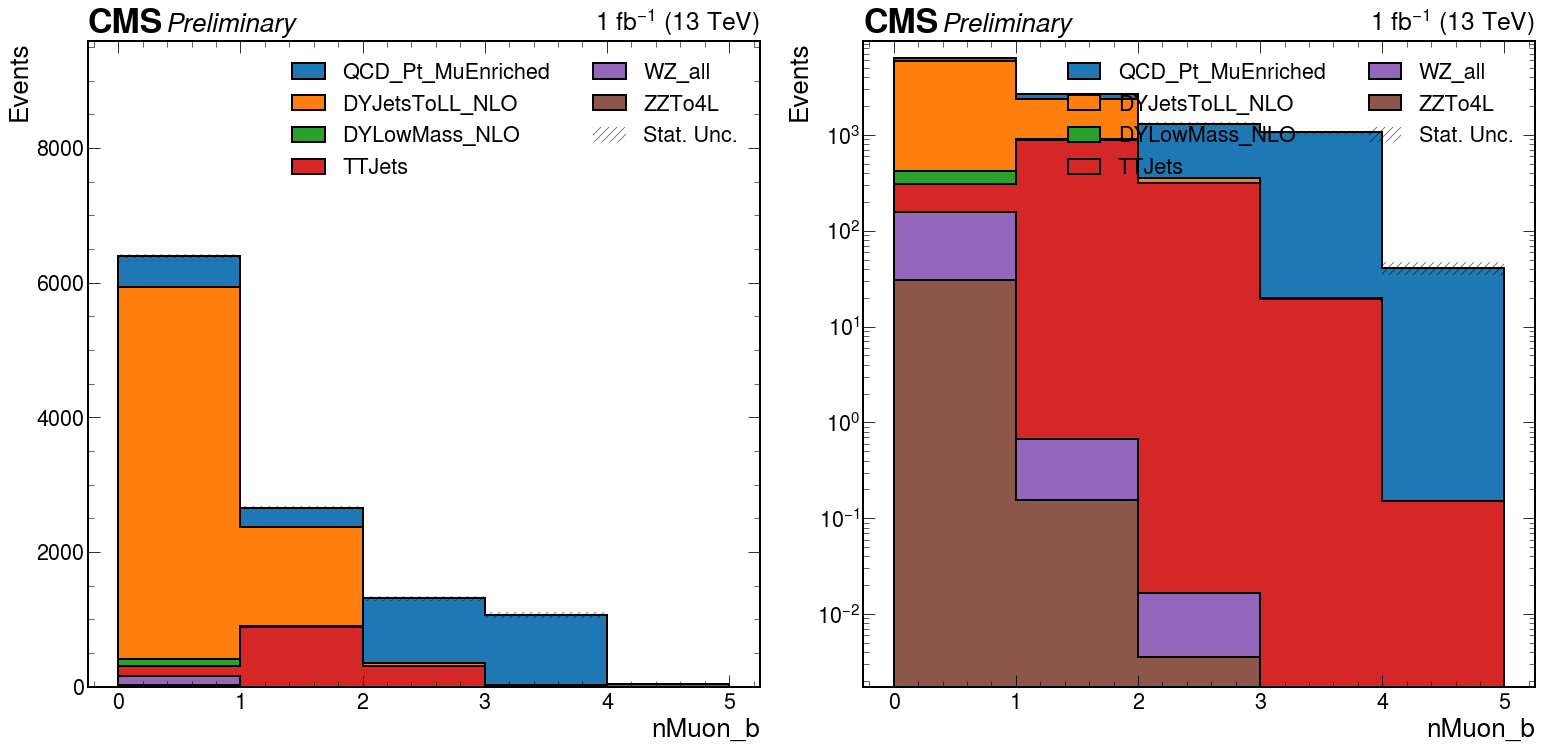

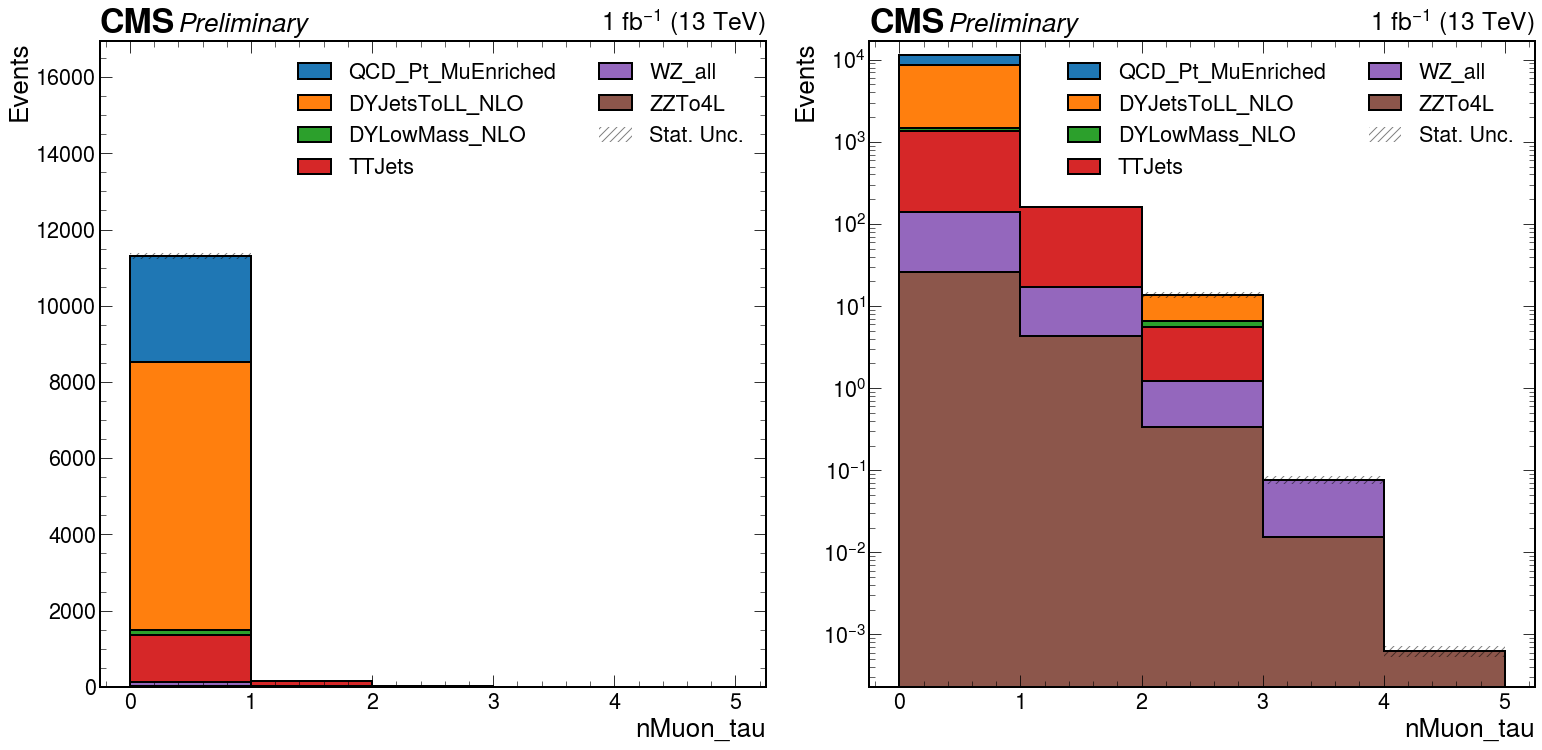

In [11]:
processes = [
    #'VVV_2018',
    #'ttZJets_2018',
    'ZZTo4L_2018',
    #'WJetsToLNu_HT_2018',
    #'WJets_inclusive_2018',
    #'WJets_all_2018',
    #'WW_all_2018', 
    'WZ_all_2018', 
    #'ST_tW_2018',
    #'ST_t-channel_2018',
    #'ST_2018',
    #'VV_2018',
    'TTJets_2018',
    #'DYCombined_2018',
    #'DYLowMass_LO_2018',
    'DYLowMass_NLO_2018',
    'DYJetsToLL_NLO_2018',
    #'DY0JetsToLL_2018',
    #'DYNJetsToLL_2018',
    'QCD_Pt_MuEnriched_2018',
    #'QCD_Pt_2018',
]
signals = [
    'SUEP-m125-darkPho_2018',
    'SUEP-m125-darkPhoHad_2018',
    'SUEP-m400-darkPho_2018',
    'SUEP-m400-darkPhoHad_2018',
]
sources = [
    'tau',
    'prompt',
    'light/other',
    'c/b',
]

plot_set = [
    [
        ('nJet_vs_nGenJet_vs_nMuon','nJet'),
        {}
    ],
    [
        ('nJet_vs_nGenJet_vs_nMuon','nGenJet'),
        {}
    ],
    [
        ('nJet_vs_nGenJet_vs_nMuon','nMuon'),
        {}
    ],
    [
        ('LHE_Njets_vs_Nglu_vs_Nuds_vs_Nc_vs_Nb_vs_nMuon','LHE_Njets'),
        {}
    ],
    [
        ('LHE_Njets_vs_Nglu_vs_Nuds_vs_Nc_vs_Nb_vs_nMuon','LHE_Nb'),
        {}
    ],
    [
        ('LHE_Njets_vs_nMuon_vs_nMuon_nonprompt_vs_nMuon_nonprompt_reco','nMuon_nonprompt'),
        {}
    ],
    [
        ('LHE_Njets_vs_nMuon_vs_nMuon_nonprompt_vs_nMuon_nonprompt_reco','nMuon_nonprompt_reco'),
        {}
    ],
    [
        (
            'nMuon_unmatched_vs_nMuon_prompt_vs_nMuon_light_vs_nMuon_c_vs_nMuon_b_vs_nMuon_tau',
            'nMuon_unmatched'
        ),
        {}
    ],
    [
        (
            'nMuon_unmatched_vs_nMuon_prompt_vs_nMuon_light_vs_nMuon_c_vs_nMuon_b_vs_nMuon_tau',
            'nMuon_prompt'
        ),
        {}
    ],
    [
        (
            'nMuon_unmatched_vs_nMuon_prompt_vs_nMuon_light_vs_nMuon_c_vs_nMuon_b_vs_nMuon_tau',
            'nMuon_light'
        ),
        {}
    ],
    [
        (
            'nMuon_unmatched_vs_nMuon_prompt_vs_nMuon_light_vs_nMuon_c_vs_nMuon_b_vs_nMuon_tau',
            'nMuon_c'
        ),
        {}
    ],
    [
        (
            'nMuon_unmatched_vs_nMuon_prompt_vs_nMuon_light_vs_nMuon_c_vs_nMuon_b_vs_nMuon_tau',
            'nMuon_b'
        ),
        {}
    ],
    [
        (
            'nMuon_unmatched_vs_nMuon_prompt_vs_nMuon_light_vs_nMuon_c_vs_nMuon_b_vs_nMuon_tau',
            'nMuon_tau'
        ),
        {}
    ],
]


for plot_i in plot_set:
    if plot_i[0][0] not in plots[processes[0]].keys():
        continue

    # Overlay for processes
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(22, 11))
    plot_utils.plot_stack(
        plots=plots, 
        bkg_list=processes, 
        label=plot_i[0], 
        fig=fig,
        ax=ax[0],
        per_muon=False,
        **plot_i[1]
    )
    plot_utils.plot_stack(
        plots=plots, 
        bkg_list=processes, 
        label=plot_i[0], 
        fig=fig,
        ax=ax[1],
        ylog=True,
        per_muon=False,
        **plot_i[1]
    )
    plt.tight_layout()
    plt.show()

KeyError: 'SUEP-m125-darkPho_2018'

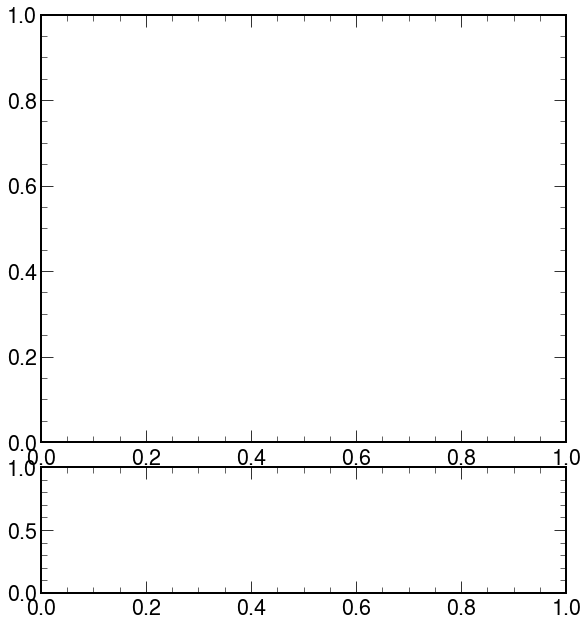

In [12]:
processes = [
    #'VVV_2018',
    #'ttZJets_2018',
    #'ZZTo4L_2018',
    #'WJetsToLNu_HT_2018',
    #'WJets_inclusive_2018',
    #'WJets_all_2018',
    #'WW_all_2018', 
    #'WZ_all_2018', 
    #'ST_tW_2018',
    #'ST_t-channel_2018',
    #'ST_2018',
    #'VV_2018',
    'TTJets_2018',
    #'DYCombined_2018',
    #'DYLowMass_LO_2018',
    'DYLowMass_NLO_2018',
    'DYJetsToLL_NLO_2018',
    #'DY0JetsToLL_2018',
    #'DYNJetsToLL_2018',
    'QCD_Pt_MuEnriched_2018',
]
signals = [
    'SUEP-m125-darkPho_2018',
    'SUEP-m125-darkPhoHad_2018',
    'SUEP-m400-darkPho_2018',
    'SUEP-m400-darkPhoHad_2018',
]

plot_set = [
    [
        ('all_pairs_deltaangle_vs_nMuon','all_pairs_deltaangle'),
        {}
    ],    
    [
        ('leading_os_dimuon_pair_pt_vs_mass','leading_os_dimuon_pair_pt'),
        {'slc': slice(None, None, 2j)}
    ],
    [
        ('leading_os_dimuon_pair_log_pt_vs_mass','leading_os_dimuon_pair_pt'),
        {
            'slc': slice(None, None, 2j),
            'xlog': True
        }
    ],
    [
        ('leading_os_dimuon_pair_pt_vs_mass','leading_os_dimuon_pair_mass'),
        {
            'slc': slice(None, None, 2j),
        }
    ],
    [
        ('leading_os_dimuon_pair_log_pt_vs_mass','leading_os_dimuon_pair_mass'),
        {
            'slc': slice(None, None, 2j),
            'xlog': True
        }
    ],
    [
        ('leading_dimuon_pair_deltaR','leading_dimuon_pair_deltaR'),
        {
            'slc': slice(None, None, 2j),
        }
    ],
]


for plot_i in plot_set:
    if plot_i[0][0] not in plots[processes[0]].keys():
        continue

    fig = plt.figure(figsize=(22, 11))
    G = gridspec.GridSpec(4, 2, figure=fig)
    left_gs = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=G[:, 0])
    right_gs = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=G[:, 1])
    plot_utils.plot_ratio_stack(
        plots=plots, 
        bkg_list=processes, 
        sig_list=signals,
        label=plot_i[0],
        ylog=False,
        override_slice=True,
        fig=fig,
        gs=left_gs,
        **plot_i[1]
    )
    plot_utils.plot_ratio_stack(
        plots=plots, 
        bkg_list=processes, 
        sig_list=signals,
        label=plot_i[0],
        ylog=True,
        override_slice=True,
        fig=fig,
        gs=right_gs,
        **plot_i[1]
    )
    plt.tight_layout()
    plt.show()
    """
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(22, 11))
    plot_utils.plot_overlay(
        plots=plots, 
        bkg_list=processes, 
        label=plot_i[0], 
        override_slice=True,
        fig=fig,
        ax=ax[0],
        per_muon=False,
        **plot_i[1]
    )
    plot_utils.plot_overlay(
        plots=plots, 
        bkg_list=processes, 
        label=plot_i[0], 
        override_slice=True,
        fig=fig,
        ax=ax[1],
        ylog=True,
        per_muon=False,
        **plot_i[1]
    )
    plt.tight_layout()
    plt.show()
    """

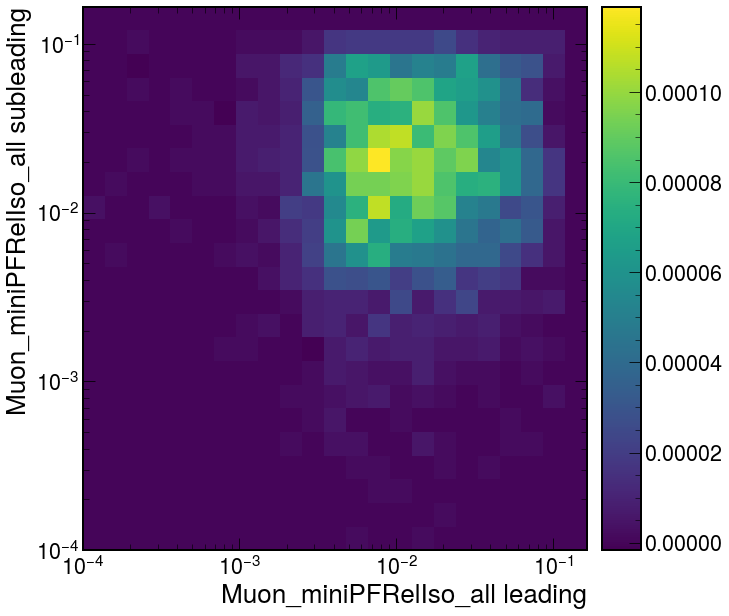

In [35]:
hep.hist2dplot(
    plots[
        'ZZZ_2018'
    ]['leading_muon_iso_vs_subleading_muon_iso'][:0.2j:2j, :0.2j:2j]
)
plt.xscale('log')
plt.yscale('log')

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f9f8d8634f0>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f9f3983c340>, text=[])

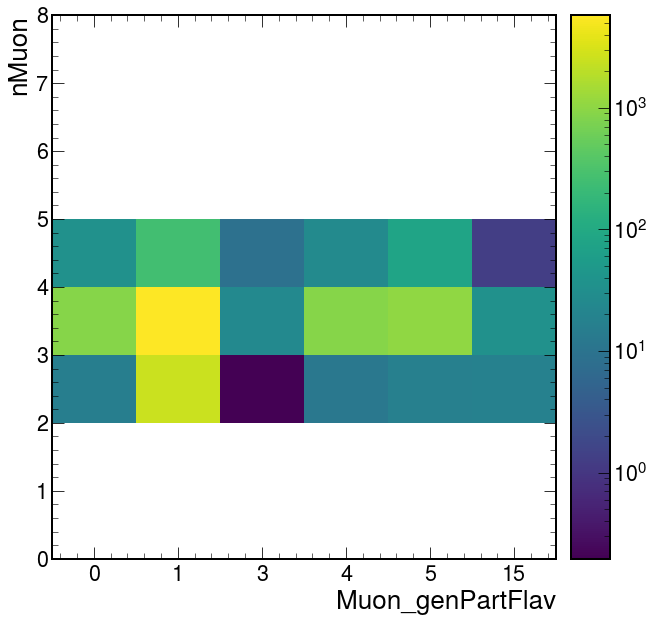

In [23]:
hep.hist2dplot(
    plots['DYJetsToLL_NLO_2018']['muon_pt_vs_genPartFlav_vs_nMuon'][::sum, :, :],
    norm=matplotlib.colors.LogNorm()
)
#plt.xscale('log')
#plt.yscale('log')

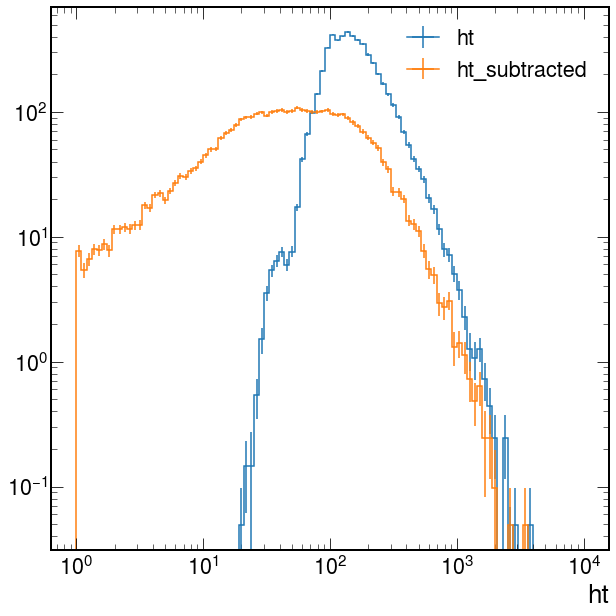

In [40]:
sample="DYJetsToLL_NLO_2018"
hep.histplot(
    plots[sample]['ht'][:, ::sum],
    label="ht"
)
hep.histplot(
    plots[sample]['ht'][::sum, :],
    label="ht_subtracted"
)
plt.legend()
plt.xscale('log')
plt.yscale('log')

In [45]:
plots["DYJetsToLL_NLO_2018"]['ht'][::sum, ::sum]

WeightedSum(value=5248.72, variance=539.628)

WeightedSum(value=5248.72, variance=539.628)

## Try to form a CR_prompt

Apply the cuts defined below to all the matching histograms:

In [15]:
pprint(list(plots['QCD_Pt_2018'].keys()))

[
│   'muon_pt_vs_genPartFlav_vs_nMuon',
│   'muon_dxy_vs_genPartFlav_vs_nMuon',
│   'muon_miniPFRelIso_vs_genPartFlav_vs_nMuon',
│   'muon_btagDeepFlavB_vs_genPartFlav_vs_nMuon',
│   'muon_matched_jetPtRelv2_vs_genPartFlav_vs_nMuon',
│   'muon_matched_jetRelIso_vs_genPartFlav_vs_nMuon'
]

In [16]:
plots['QCD_Pt_2018']['muon_pt_vs_genPartFlav_vs_nMuon']

Hist(
  Regular(50, 3, 500, transform=log, name='Muon_pt', label='Muon_pt'),
  IntCategory([0, 1, 3, 4, 5, 15], name='Muon_genPartFlav', label='Muon_genPartFlav'),
  Regular(8, 0, 8, name='nMuon', label='nMuon'),
  storage=Weight()) # Sum: WeightedSum(value=472.374, variance=20756) (WeightedSum(value=472.39, variance=20756) with flow)

In [17]:
cut = [
    {'name': "nMuon", 'slice': slice(4j, 5j)},
]
full_slice = plot_utils.cut_to_sum_slice(
    plots['QCD_Pt_2018']['muon_pt_vs_genPartFlav_vs_nMuon'], 
    cut
)
print(full_slice)

(slice(None, None, <built-in function sum>), slice(None, None, <built-in function sum>), slice(4j, 5j, <built-in function sum>))


In [19]:
cuts = [
    {
        'name': "nMuon", 'slice': slice(4j, 5j)
    },    
]

plots_cut = plot_utils.apply_cuts(plots, cuts)

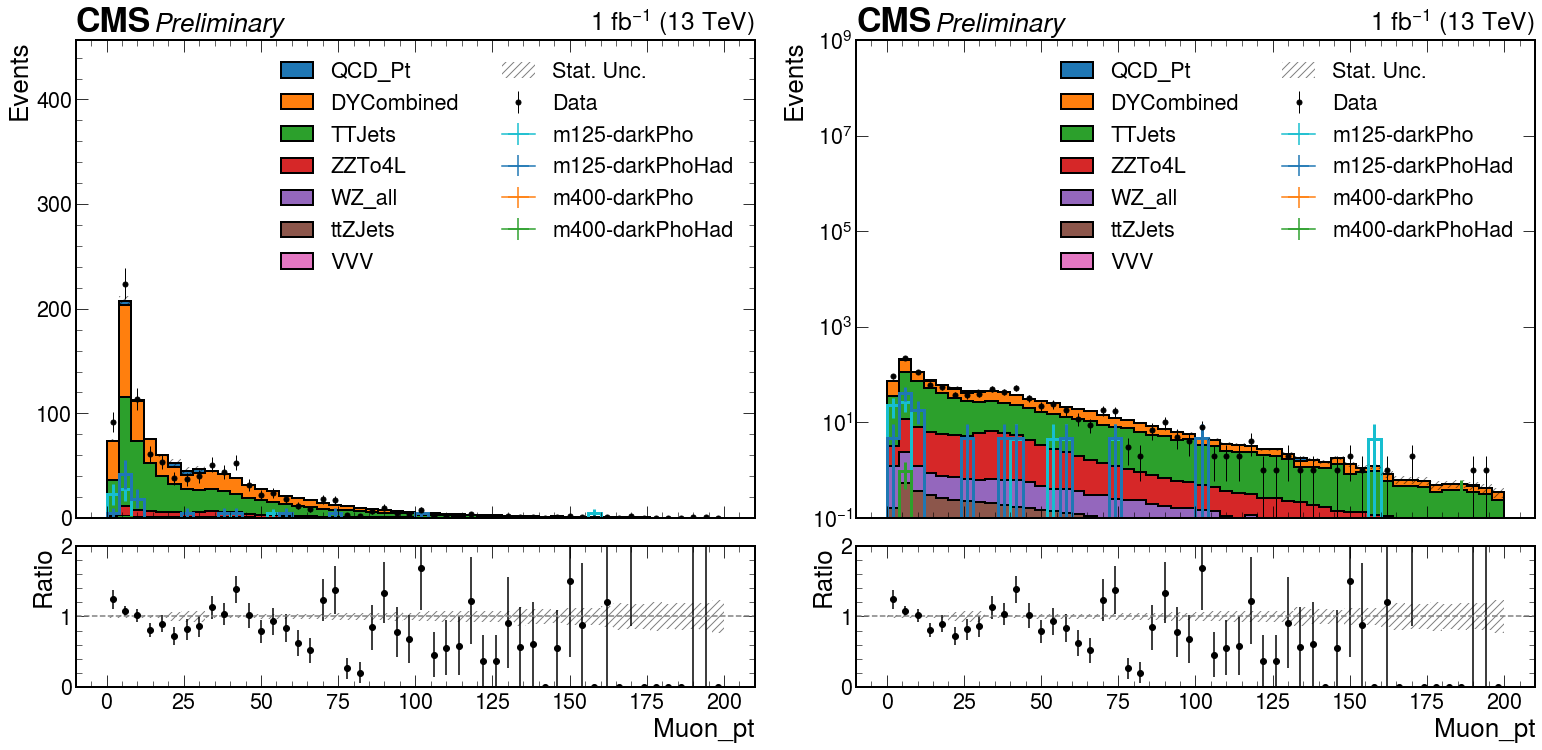

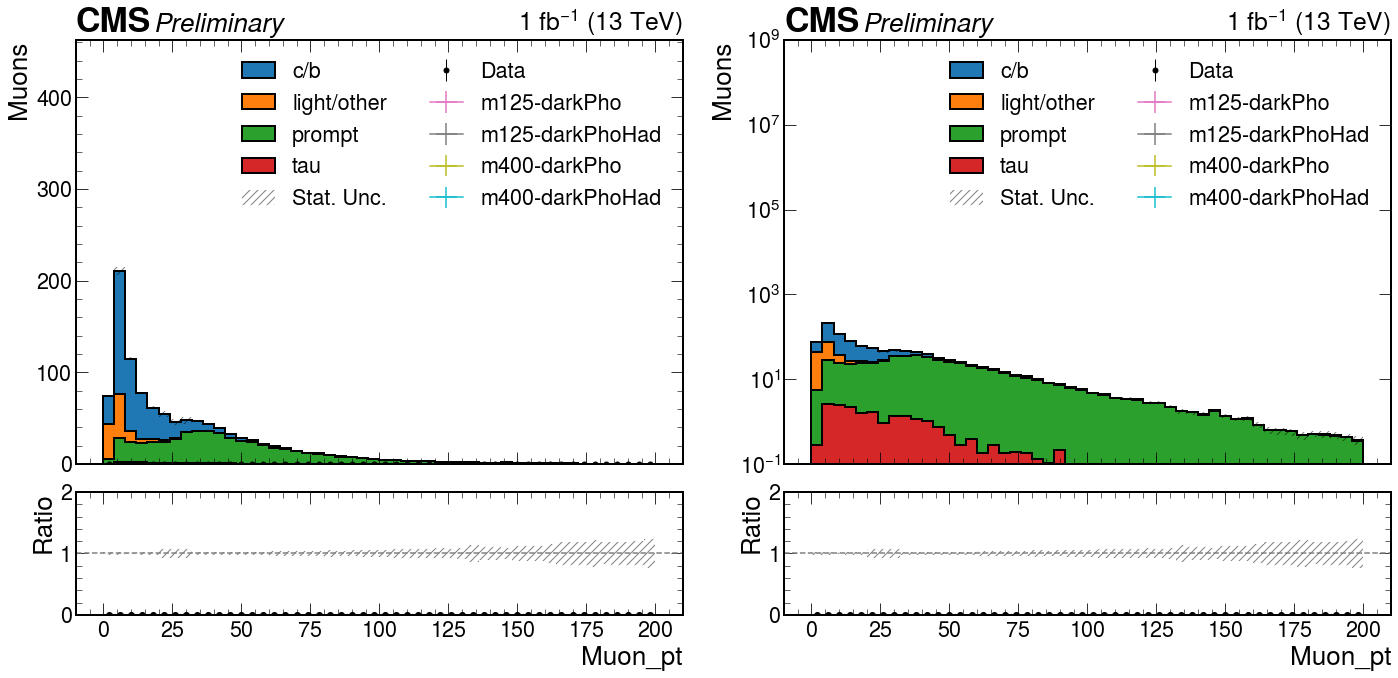

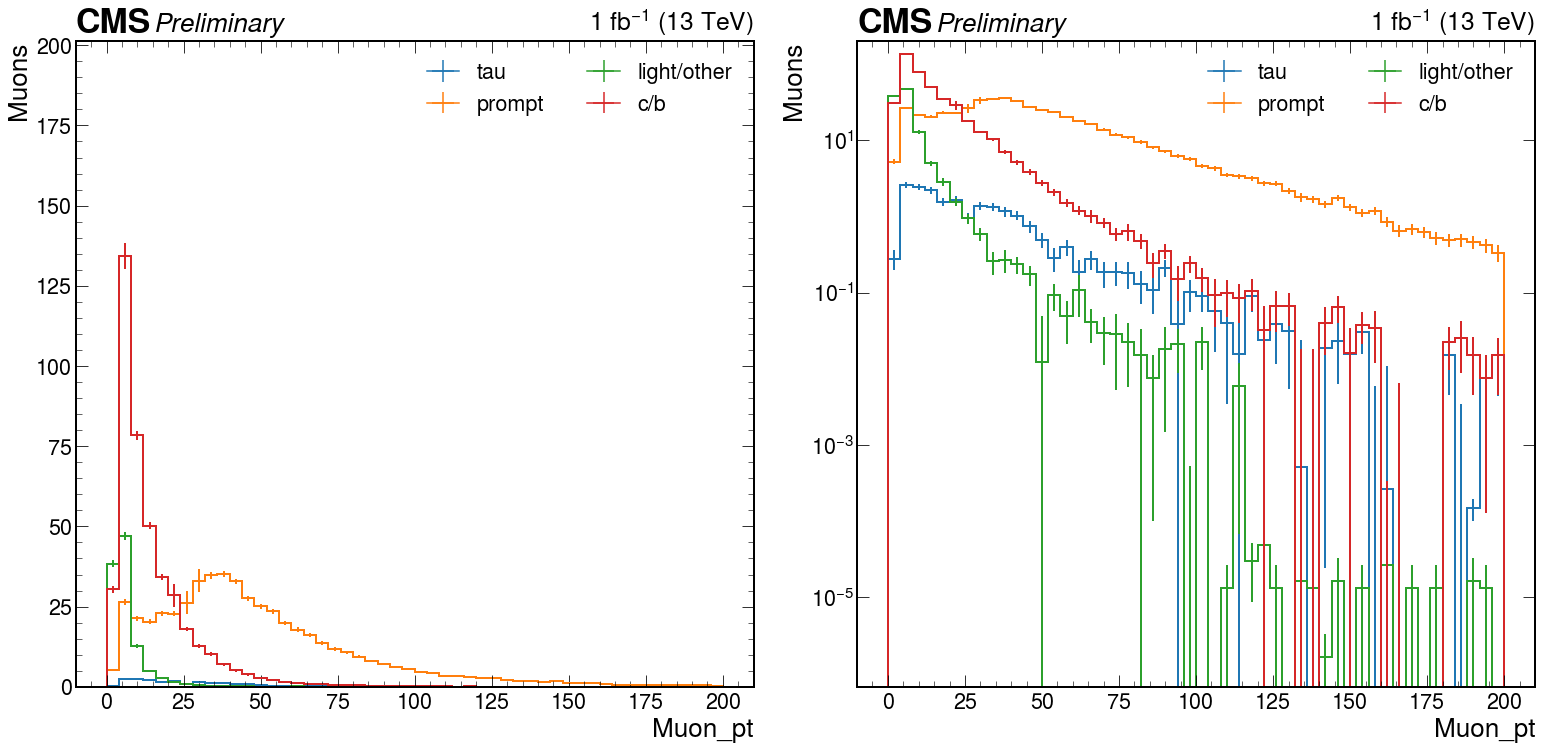

In [24]:
processes = [
    'VVV_2018',
    'ttZJets_2018',
    'ZZTo4L_2018',
    'TTJets_2018',
    'DYCombined_2018',
    'QCD_Pt_2018',
]
signals = [
    'SUEP-m125-darkPho_2018',
    'SUEP-m125-darkPhoHad_2018',
    'SUEP-m400-darkPho_2018',
    'SUEP-m400-darkPhoHad_2018',
]
sources = [
    'tau',
    'prompt',
    'light/other',
    'c/b',
]
cuts = [
    [
        {'name': "nMuon", 'slice': slice(4j, 5j)},
    ]
]

plot_set = [
    [
        ('muon_pt_linear_vs_genPartFlav_vs_nMuon','Muon_dxy'),
        {'xlog': False}
    ],
]

for cut in cuts:
    for plot_i in plot_set:
        if plot_i[0][0] not in plots[processes[0]].keys():
            continue
        # Convert the cut from single axis to full histogram slice/sum
        full_slice = plot_utils.cut_to_sum_slice(plots[processes[0]][plot_i[0][0]], cut)
        
        fig = plt.figure(figsize=(22, 11))
        G = gridspec.GridSpec(4, 2, figure=fig)
        left_gs = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=G[:, 0])
        right_gs = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=G[:, 1])
        plot_utils.plot_ratio_stack(
            plots=plots, 
            bkg_list=bkgs, 
            sig_list=signals,
            label=plot_i[0],
            ylog=False,
            cut=full_slice,
            override_slice=True,
            fig=fig,
            gs=left_gs,
            **plot_i[1]
        )
        plot_utils.plot_ratio_stack(
            plots=plots, 
            bkg_list=bkgs, 
            sig_list=signals,
            label=plot_i[0],
            ylog=True,
            cut=full_slice,
            override_slice=True,
            fig=fig,
            gs=right_gs,
            **plot_i[1]
        )
        plt.tight_layout()
        plt.show()

        
        full_slice = plot_utils.cut_to_sum_slice(
            plots['prompt'][plot_i[0][0]], cut
        )
        fig = plt.figure(figsize=(20, 10))
        G = gridspec.GridSpec(4, 2, figure=fig)
        left_gs = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=G[:, 0])
        right_gs = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=G[:, 1])
        plot_utils.plot_ratio_stack(
            plots=plots, 
            bkg_list=sources, 
            sig_list=signals,
            label=plot_i[0],
            ylog=False,
            cut=full_slice,
            override_slice=True,
            fig=fig,
            gs=left_gs,
            per_muon=True,
            **plot_i[1]
        )
        plot_utils.plot_ratio_stack(
            plots=plots, 
            bkg_list=sources, 
            sig_list=signals,
            label=plot_i[0],
            ylog=True,
            cut=full_slice,
            override_slice=True,
            fig=fig,
            gs=right_gs,
            per_muon=True,
            **plot_i[1]
        )
        plt.tight_layout()
        plt.show()
        
        fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(22, 11))
        plot_utils.plot_overlay(
            plots=plots, 
            bkg_list=sources, 
            label=plot_i[0], 
            cut=full_slice,
            override_slice=True,
            fig=fig,
            ax=ax[0],
            per_muon=True,
            **plot_i[1]
        )
        plot_utils.plot_overlay(
            plots=plots, 
            bkg_list=sources, 
            label=plot_i[0], 
            cut=full_slice,
            override_slice=True,
            fig=fig,
            ax=ax[1],
            ylog=True,
            per_muon=True,
            **plot_i[1]
        )
        plt.tight_layout()
        plt.show()